# Assignment 2 - Mattéo Menager - 20105354

The purpose of this assignment is to analyse the Bike Sharing Dataset hosted on the UCI repository of datasets.

The dataset is provided with this notebook as a zip file.

There are two related datasets in the zip file: one aggregated by day, and the other aggregated by hour.

They represent the number of bikes that were shared/hired in Washington over that time period, together with the factors that are believed to predict the demand for such bikes.

They include the time unit and various measures of the weather etc. (in terms of temperature, humidity and wind-speed). More description can be found [here](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset).

You are asked to

1. Read the _hourly_ data and split into training and test data __[5 marks]__
2. For the _training data_ only, use exploratory data analysis to learn about the data and to indicate how to build a model __[15 marks]__
3. Using a forward selection approach, build a regression model that offers the best performance, using a machine learning measure (i.e., prediction accuracy on the test data) __[30 marks]__
   - You need to pay particular attention to the regression model assumptions
   - For best performance, you will also need to perform feature engineering
     - modifying the existing features
     - transforming them
     - merging them
     - keeping feature correlation as low as possible
   - 10-fold cross-validation should be used to estimate the uncertainty in the fitted model parameters.
4. Identify the 3 target columns. Which of these target columns is easiest to predict accurately? __[5 marks]__
5. Using this "preferred target", derive a new target whose values are the grouped label (taking the values `Q1`, `Q2`, `Q3`, `Q4`) for demand in the quartiles (0 < demand <= 25th percentile of demand), (25th percentile of demand < demand <= 50th percentile of demand), .. You might find the [pandas quantile calculator](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html) convenient when computing the quartile end points (25th, 50th and 75th percentiles), and pandas filtering by rows  convenient for assigning the new labels. __[5 marks]__
6. Use _two_ classification procedures to predict these demand quartiles, repeating the forward selection procedure to find the best model for each, but this time focusing on classification accuracy on the test set as the measure of performance. Are the same features used in each of the two models? __[35 marks]__
7. Which of the two machine learning procedures (regression and classification) provides the highest classification accuracy on the test set? Why is this? __[5 marks]__

# Notes on running this notebook. 

This notebook can be run using the `data-mining` anaconda environment created at the beginning of the semester. 

This environment is a regular anaconda environment with the following packages added: `dtale`, `voila`, `feature-tools`, `graphviz`, `pydot`, `ipywidgets`, `phik`, `pingouin`.

The Python version of this environment is `3.11.5`.

This notebook is designed to be ran all at once. Avoid running cells out of order or multiple times.

# Task 1: Read the _hourly_ data and split into training and test data.

## 1.1 Importing libraries

Before anaything, we will import the libraries we will need for this notebook : some core data science modules, statistical modules and some visualisations modules. 

In [1]:
# core data science libraries
import numpy as np
import pandas as pd

# statistical modules
import scipy.stats as stats 
import statsmodels.api as sm 
import pingouin as pg

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

# set the default style for plots
plt.style.use("seaborn-darkgrid")

# matplotlib magic to show plots inline
%matplotlib inline

/var/folders/dt/58d383mx6m5glpsgpmmsbj_80000gn/T/ipykernel_14151/1283187840.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


## 1.2 Importing the data and fixing column names

Next, we need to import our dataset into a pandas dataframe.

In [2]:
df = pd.read_csv('data/hour.csv', index_col='instant', parse_dates=['dteday'])
df.head(2)

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40


We just need to change some columns names to make them more readable.

In [3]:
df.rename(columns={'weathersit':'weather', 'mnth':'month', 'hr':'hour', 'yr':'year', 'hum':'humidity', 'cnt':'count', 'temp':'temperature', 'atemp':'feel_temp', 'dteday':'date'}, inplace=True)
df.head(2)

,date,season,year,month,hour,holiday,weekday,workingday,weather,temperature,feel_temp,humidity,windspeed,casual,registered,count
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40


We can also add `hour` to the `date` column and use this datetime as a Pandas DataTimeIndex for our dataframe. This can be useful for visualisations and querying our data.

In [4]:
df['date'] = df.date + pd.to_timedelta(df.hour, unit='h')
df.set_index(pd.DatetimeIndex(df['date']), inplace=True)
df.drop('date', axis=1, inplace=True)
df.head()


,season,year,month,hour,holiday,weekday,workingday,weather,temperature,feel_temp,humidity,windspeed,casual,registered,count
date,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2011-01-01 01:00:00,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2011-01-01 02:00:00,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
2011-01-01 03:00:00,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
2011-01-01 04:00:00,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


For now, we don't touch the datatypes and features of the dataset. We will first split the dataset into a training and a test set. Then, we will do some exploratory data analysis on the training set to see if we need to do feature engineering before building a model.

## 1.3 Splitting the dataset 

We will split the dataset into a training and a test set. We will use the training set to build our model and the test set to evaluate it.

The building phase of the model will be done using 10-fold cross-validation and a forward selection approach. At each step of the forward selection, we will use the average cross-validation score to evaluate each model and select the best feature (best score among the models) to keep for the next step (if accuracy is still increasing).

Once we have selected all the features to keep in the final model, we will train the model on the whole training set and evaluate it on the test set.

In [5]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
print(f"Train set shape: {train_set.shape}")
print(f"Test set shape: {test_set.shape}")

Train set shape: (13903, 15)
Test set shape: (3476, 15)


# Task 2: For the training data only, use exploratory data analysis to learn about the data and to indicate how to build a model

## 2.1 Inspecting the dataset

In [6]:
df.tail()

,season,year,month,hour,holiday,weekday,workingday,weather,temperature,feel_temp,humidity,windspeed,casual,registered,count
date,,,,,,,,,,,,,,,
2012-12-31 19:00:00,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
2012-12-31 20:00:00,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
2012-12-31 21:00:00,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
2012-12-31 22:00:00,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61
2012-12-31 23:00:00,1,1,12,23,0,1,1,1,0.26,0.2727,0.65,0.1343,12,37,49


So far so good, we do not have extraneous values at the end and the dataset looks fine overall. 

We can now check if all the targets have been recorded correctly (`count` should always be the sum of casual and registered users).

In [7]:
# check that casual + registered = count for all rows
(df['casual'] + df['registered'] == df['count']).value_counts()

True    17379
dtype: int64

This is perfect. 

We can now look at the datatypes of our columns, and start to think about how we will treat each of them.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       17379 non-null  int64  
 1   year         17379 non-null  int64  
 2   month        17379 non-null  int64  
 3   hour         17379 non-null  int64  
 4   holiday      17379 non-null  int64  
 5   weekday      17379 non-null  int64  
 6   workingday   17379 non-null  int64  
 7   weather      17379 non-null  int64  
 8   temperature  17379 non-null  float64
 9   feel_temp    17379 non-null  float64
 10  humidity     17379 non-null  float64
 11  windspeed    17379 non-null  float64
 12  casual       17379 non-null  int64  
 13  registered   17379 non-null  int64  
 14  count        17379 non-null  int64  
dtypes: float64(4), int64(11)
memory usage: 2.1 MB


*Important note : Until now we used the original dataset as we just checked if there was no error in it. From now, on we will only use the training split as we do not want to insert any knowledge from the test set in our analysis.*

**Null values**

All the other columns are treated as numerical and show 100% non-null values (no NaN). As we will see, we don't want to treat them all as numerical features but this is good as it means we do not have extraneous values (non-null strings) in the dataset (if it was the case, the columns would have been treated as `object` type.)

**Targets**

Nothing to say about the targets (`casual`, `registered` and `count`), types are correct. Dataset is clean in that regard.

**Weather metrics**

Even though all columns have a numerical datatype for now, we only have 4 numerical features : `temperature`, `feel_temp`, `humidity` and `windspeed`. There is no problem with their type, however we can see in the documentation (and this is confirmed by looking at the actual values in the dataset) that they all have been scaled (divided by their max value). This scaling has the same effect as the `MaxAbsScaler` because their max valaue is also their maximum absolute value. However, this scaling is not robust to outliers so we will see later if we need to change the scaling. Note that scaling is not necessary for regression, but it is not a bad thing and will be necessary for classification, so we can do it now.

We might also need to perform PCA on these metrics as they are certainly related and maybe even drop `feel_temp` as it is certainly highly correlated with `temperature`. Our principal components might also be linked to the `weather` categorical variable so there might be something to do as well. But this is for later.

> Next step for weather metrics : Leave them as they are for now. Potentially change the scaling later if needed. Perform PCA if it makes sense.

**Other features**

`weather` has a natural order so we will try 2 different strategies and forward selection will tell us which one works best :
- Treat it as a numerical feature, we will also compute functions of it (powers, log, exp, etc.) and see if it improves the model.
- Treat it as a categorical feature, we will use one-hot encoding to create dummy variables for each category (-1). This could be useful if for example only one condition has a real effect on demand.

`workingday` is good as it is (binary categorical feature).

`holiday` is good as it is in terms of encoding (binary categorical feature) but it might be redundant information with `workingday` since it is already included in the definition of `workingday`. It is also a very imbalanced feature (2.8% true values) so its fitted coefficient might have a lot of uncertainety (very different values depending on the training set/folds). We will drop it.

For `hour`, `month`, `season` and `weekday` we will use cyclic variables. This will allow use to keep the proximity information in the data and will result in far less features than one-hot encoding. However as some hours show peaks in demand, we will add dummy variables for these peak periods. We will also try to combine these peak periods dummies with the workingday variable as it would make sense (especially for the registered users, see EDA). Since tehre are not many seasons, we can also try to create dummies for seasons as it would result in only 3 dummies. If our cyclical approach for hour and month is not successful, we can try to create dummies for these features as well, but it would require adding many dimensions, which I think is not ideal for model performance. 

>Next steps for other features :
>- Drop `holiday`
>- Compute functions of `weather` 
>- Create dummies for `weather`
>- Create cyclic variables for `hour`, `month`, `season` and `weekday`
>- Create dummies for peak periods of `hour` 
>- Combine peak periods of `hour` with `workingday` (for registered and count)
>- Combine hour yclic variables and `workingday` (for casual)
>- Create dummies for `season`

**Year feature**

I took me quite some time to decide what to do with `year`. 

The reason is there is almost no doubt that including `year` in the model will increase prediction accuracy on the test set, as there is definitely a realtionship between `year` and the hourly number of bikes rented (see boxplots below). In fact, we can see on the boxplots below that the number of users is noticibly higher in 2012 than in 2011. This makes sense as the bike sharing system certainely gains popularity over the years which corresponds to a positive relationship between year and our targets. However, this relationship might not be linear, it could rather be log shaped for example as the number of users might face a ceiling at some point (either because it has become mainstream or because the infrastructure/number of bikes will not allow more users).

However, the purpose of building a predictive model is to predict future data, and including `year` in the model would prevent it from generalizing well for future years as we do not have enough years of data to estimate the nature of the relationship (whether it is loged shapped or not for example). Even if we had this, we should still be careful as extrapolating the relationship to future years might not be accurate.

Given all of that, the wiser approach could be to drop the `year` column and to try to build a prediction model solely based on weather conditions and other "calendar related features" such as `workingday`, `season`, etc. However this approach might not perform well nor on the tes set (with past data) nor on future data as the popularity of the system certainely is a very big factor in the number of users.

In a real world scenario, if let's say the bikesharing company hired us to create a model to predict future number of users on an hourly basis, we would certainely have data until the moment we are building the model. Assuming we are in 2023, and we thus have data for something like 11 years, we could potentially have a better idea of the nature/shape of the relationship between `year` and the number of users. However a more "precise" and direct measure of the popularity of the system may be the number total of registered users (not registered users bike rentals but users that have an active subscription in general). Even if the task would still be to extrapolate beyond the range of the data (for number of registered users on the system, assuming that it is still growing) it might be more accurate than using `year` as a predictor.

Since we do not have access to this data, we will use `year` as a way to account for the growing number of users over the years. However, we should bear in mind the implications of this choice. We should be aware that the model might not do as well on future data (let's say 2013) and that it might get worse as we get further from the range of the data (2014, 2015, etc.). Thus, recomputing the model every so often might be necessary, and using the number of registered users on the system might be a better approach if it was possible.

Lastly, if for exemple in 2030 the number of users overall has not grown for 5 years, we might test two different models to see which one performs best : one not accounting for the growing number of users with training data from 2025+ and one accounting for the growing number of users with training data from the beginning (assuming we have a good representation of the relationship with a flat shape from 2025).

> Next step for `year` : We can leave `year` as it is for building the model. We will create another column with the real years "labels" for EDA as it will be clearer on visualisations. Also we will treat year as categorical for EDA as we only have 2 different years (calculating correlations of of that would not make much sense). 

**Summary**

Everything that has been described above will result in creating many features, with undoubtedly a lot of them being correlated with each other. We will explore this in more detail thereafter in the EDA part. We take this approach because we will build the model using a forward selection approach which will help us decide which combination of features to keep for best performance. However it is our role to verify that the features selected make sense and are not inter-correlated (which would be appearant if we have very high regression coefficients with opposite signs for example).

<AxesSubplot: xlabel='year', ylabel='registered'>

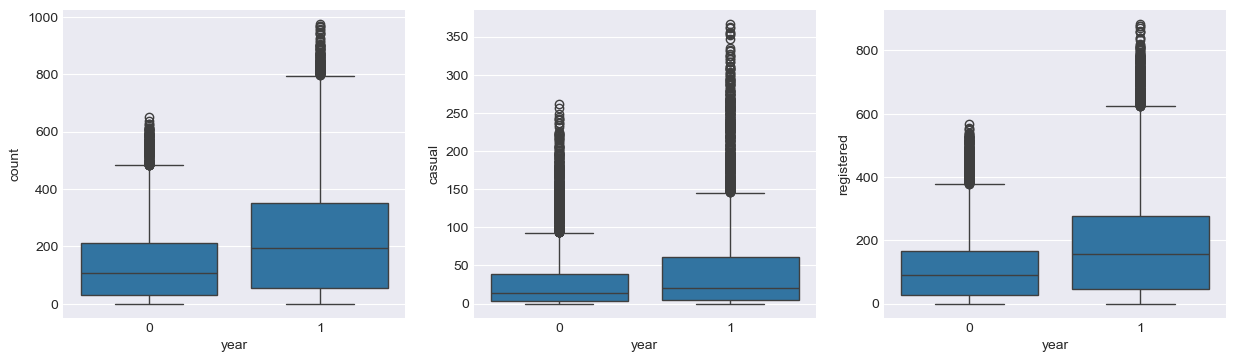

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False, sharex=False)
sns.boxplot(x='year', y='count', data=train_set, ax=axes[0])
sns.boxplot(x='year', y='casual', data=train_set, ax=axes[1])
sns.boxplot(x='year', y='registered', data=train_set, ax=axes[2])

## 2.2 Exploratory Data Analysis

We now have a good intuition of what we should do to prepare our dataset for regression, but we first need to look at the data to determine more precisely what feature engineering we should do (for example, look at the relationship between `count` and `temperature`, to see if a linear, a quadratic or log feature is more appropriate).

We will perform further EDA on our engineered features once they will be created in the next part.

Let's start by creating a new dataframe more suited for EDA of the original features.

*Note that there seems to be an error in the documentation for the mapping of `season` (it says january in in spring, etc), they seem to be shifted. Also weeks start on Sunday in the dataset (0).*

In [10]:
df_EDA = train_set.copy()
df_EDA.season = pd.Categorical(df_EDA.season.map({2:'spring', 3:'summer', 4:'fall', 1:'winter'}), categories=['spring', 'summer', 'fall', 'winter'], ordered=True)
df_EDA.year = pd.Categorical(df_EDA.year.map({0:2011, 1:2012}), categories=[2011,2012], ordered=True)
df_EDA.hour = pd.Categorical(df_EDA.hour, categories=[i for i in range(24)], ordered=True)
df_EDA.month = pd.Categorical(df_EDA.month.map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}), categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'], ordered=True)
df_EDA.weekday = pd.Categorical(df_EDA.weekday.map({0:'Sun', 1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat'}), categories=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'], ordered=True)
df_EDA.weather = pd.Categorical(df_EDA.weather.map({1:'Clear', 2:'OK', 3:'Bad', 4:'Very bad'}), categories=['Clear', 'OK', 'Bad', 'Very bad'], ordered=True)
df_EDA.workingday = pd.Categorical(df_EDA.workingday.map({0:'No', 1:'Yes'}), categories=['No', 'Yes'])
df_EDA.holiday = pd.Categorical(df_EDA.holiday.map({0:'No', 1:'Yes'}), categories=['No', 'Yes'])
df_EDA.temperature = df_EDA.temperature * 41
df_EDA.feel_temp = df_EDA.feel_temp * 50
df_EDA.humidity = df_EDA.humidity * 100
df_EDA.windspeed = df_EDA.windspeed * 67
df_EDA.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temperature,feel_temp,humidity,windspeed,casual,registered,count
date,,,,,,,,,,,,,,,
2011-01-15 11:00:00,winter,2011,Jan,11,No,Sat,No,Clear,8.20,9.850,55.0,15.0013,18,54,72
2011-10-25 18:00:00,fall,2011,Oct,18,No,Tue,Yes,Clear,21.32,25.000,42.0,7.0015,65,453,518
2011-12-07 03:00:00,fall,2011,Dec,3,No,Wed,Yes,Bad,18.86,22.725,100.0,15.0013,0,3,3
2011-04-03 18:00:00,spring,2011,Apr,18,No,Sun,No,OK,18.86,22.725,31.0,0.0000,71,101,172
2011-12-25 06:00:00,winter,2011,Dec,6,No,Sun,No,Clear,8.20,11.365,75.0,7.0015,0,1,1


In [11]:
df_EDA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13903 entries, 2011-01-15 11:00:00 to 2012-10-25 08:00:00
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   season       13903 non-null  category
 1   year         13903 non-null  category
 2   month        13903 non-null  category
 3   hour         13903 non-null  category
 4   holiday      13903 non-null  category
 5   weekday      13903 non-null  category
 6   workingday   13903 non-null  category
 7   weather      13903 non-null  category
 8   temperature  13903 non-null  float64 
 9   feel_temp    13903 non-null  float64 
 10  humidity     13903 non-null  float64 
 11  windspeed    13903 non-null  float64 
 12  casual       13903 non-null  int64   
 13  registered   13903 non-null  int64   
 14  count        13903 non-null  int64   
dtypes: category(8), float64(4), int64(3)
memory usage: 979.8 KB


Our new dataframe contains the labels and has the datatypes we want for EDA. 

We will first compute summary statistics and look at the distributions of our features and targets.

In [12]:
casual_ratio = df_EDA['casual'].sum() / df_EDA['count'].sum()
casual_ratio

0.18891241032113235

Sidenote : We can see that only 18% of bikes are rented by casual users so relationships with `count` will likely be very influenced by `registered`.

In [13]:
df_EDA.describe()

,temperature,feel_temp,humidity,windspeed,casual,registered,count
count,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000
mean,20.393246,23.809149,62.701144,12.718082,36.002374,154.574696,190.577070
std,7.913677,8.615413,19.280119,8.193602,49.636195,152.035090,182.220507
min,0.820000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.940000,16.665000,47.000000,7.001500,4.000000,34.000000,39.000000
50%,20.500000,24.240000,63.000000,11.001400,17.000000,116.000000,143.000000
75%,27.060000,31.060000,78.000000,16.997900,49.000000,221.500000,282.000000
max,41.000000,50.000000,100.000000,56.996900,367.000000,885.000000,976.000000


temperature       AxesSubplot(0.125,0.53;0.168478x0.35)
feel_temp      AxesSubplot(0.327174,0.53;0.168478x0.35)
humidity       AxesSubplot(0.529348,0.53;0.168478x0.35)
windspeed      AxesSubplot(0.731522,0.53;0.168478x0.35)
casual            AxesSubplot(0.125,0.11;0.168478x0.35)
registered     AxesSubplot(0.327174,0.11;0.168478x0.35)
count          AxesSubplot(0.529348,0.11;0.168478x0.35)
dtype: object

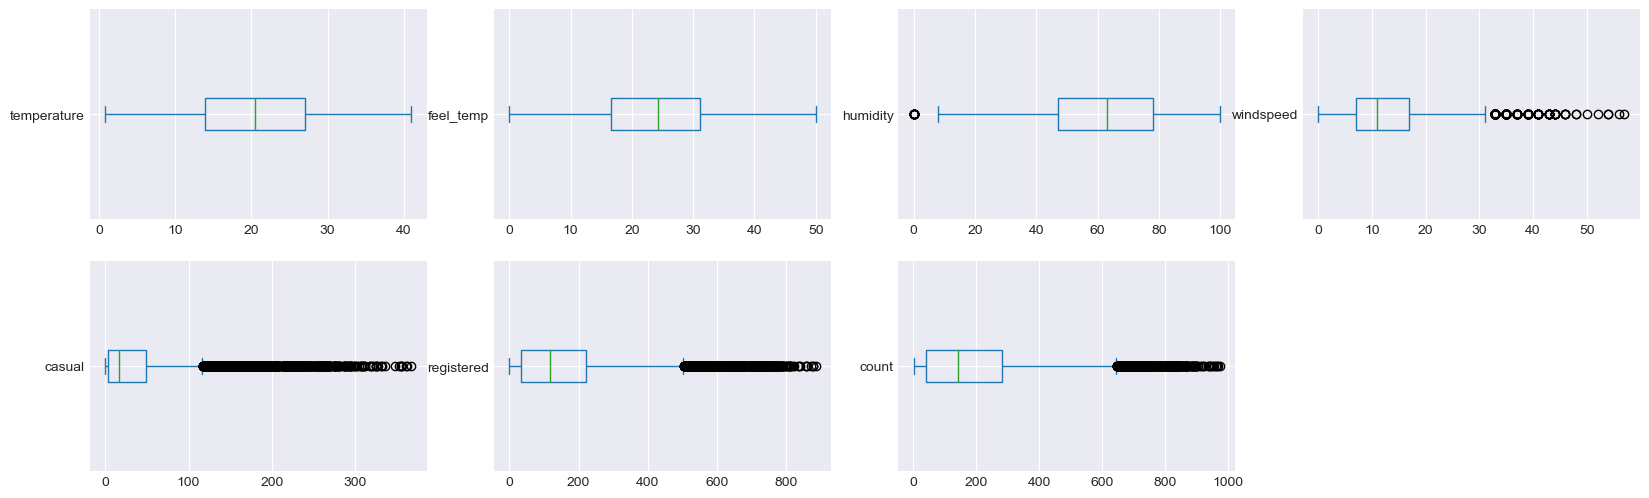

In [14]:
df_EDA.plot(kind='box', figsize=(20,6), subplots=True, layout=(2,4), sharex=False, sharey=False, vert=False)

In [15]:
numericals = ['temperature', 'feel_temp', 'humidity', 'windspeed']
categoricals = ['season', 'year', 'month', 'hour', 'weekday', 'weather', 'workingday', 'holiday']
targets = ['casual', 'registered', 'count']

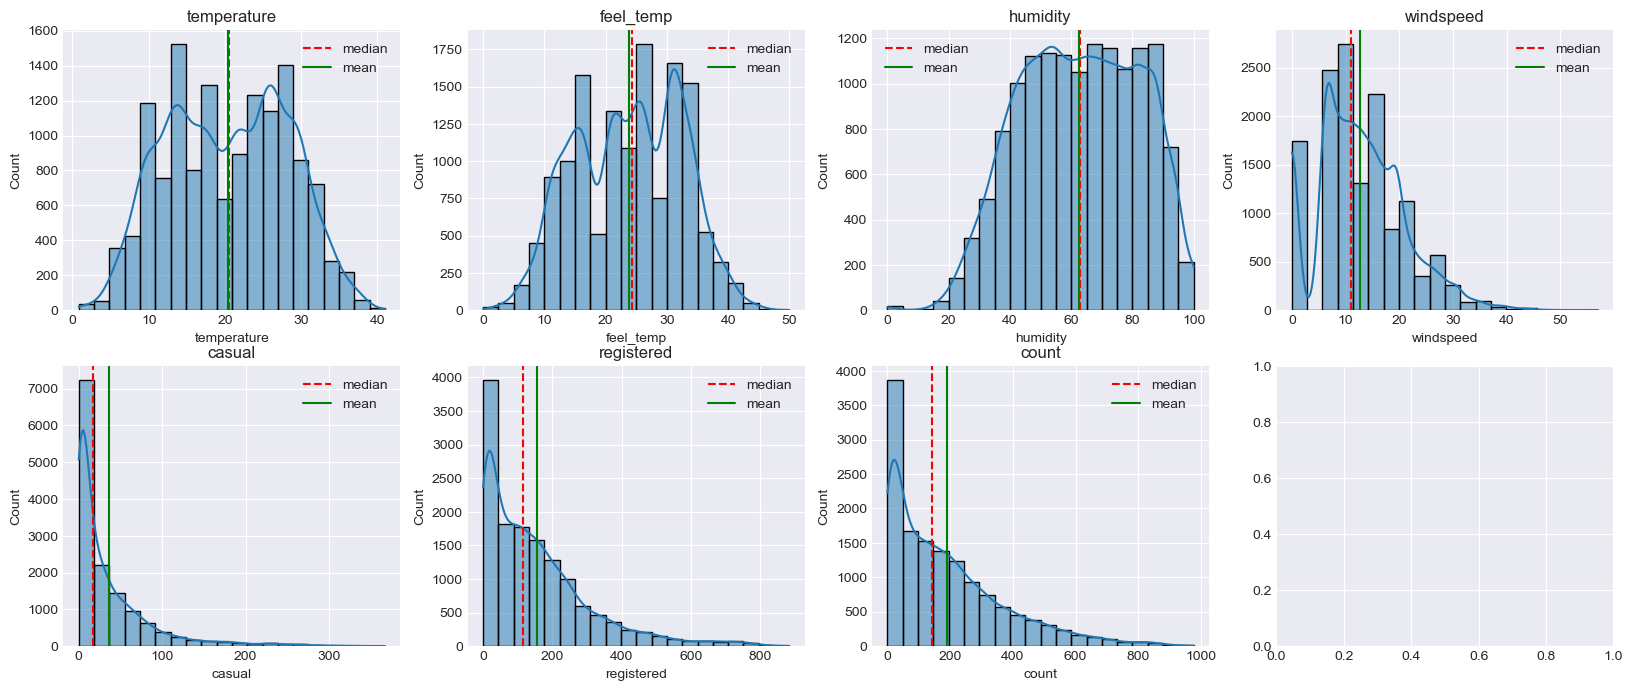

In [16]:
fig, axes = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(20, 8))
for column, ax in zip(numericals + targets, axes.flatten()):
    sns.histplot(df_EDA[column], kde=True, ax=ax, bins=20)
    # plot median and mean as vertical lines
    ax.axvline(df_EDA[column].median(), color='r', linestyle='--', label='median')
    ax.axvline(df_EDA[column].mean(), color='g', linestyle='-', label='mean')
    ax.set_title(column)
    ax.legend()

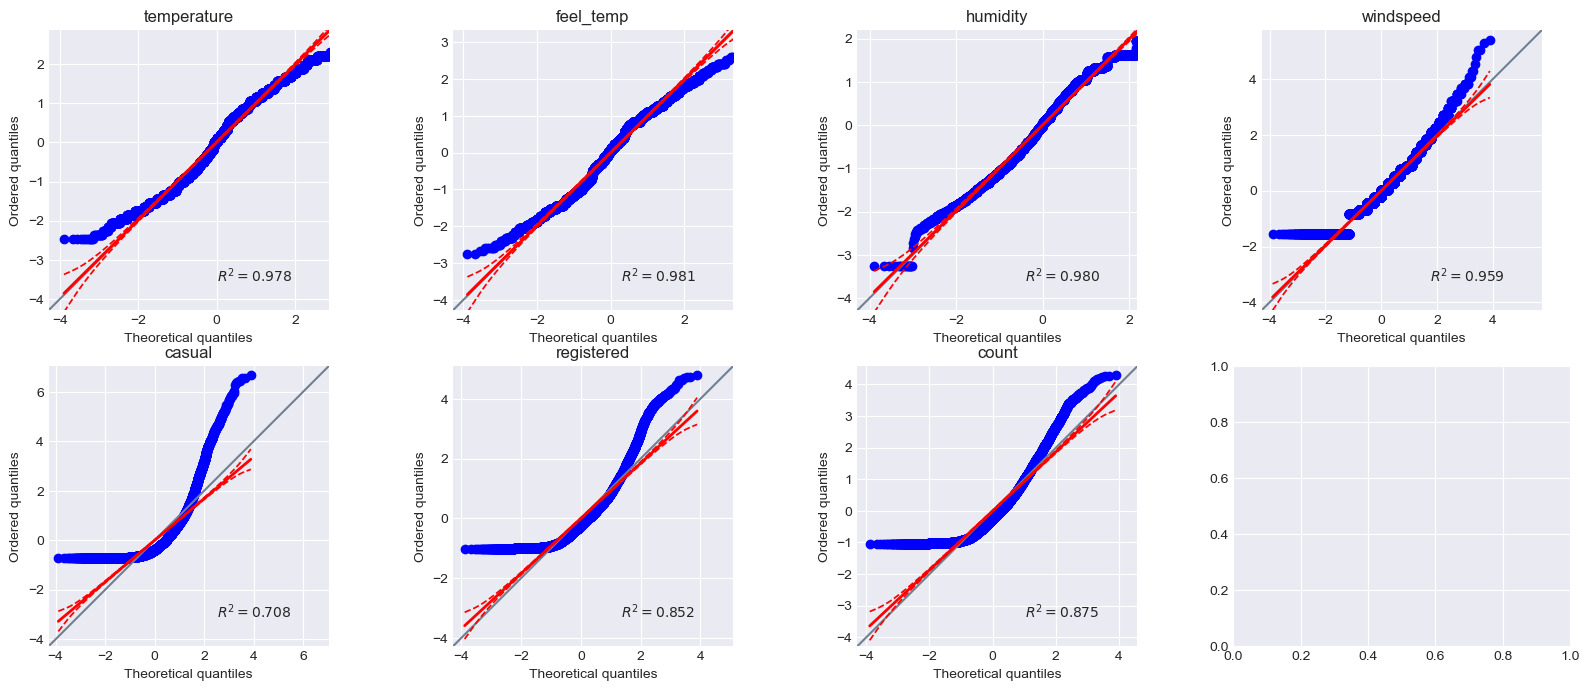

In [17]:
fig, axes = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(20, 8))
for column, ax in zip(numericals + targets, axes.flatten()):
    pg.qqplot(df_EDA[column], dist='norm', ax=ax)
    ax.set_title(column)

We can see that our numerical features are relatively well distributed (relatively normal) and do not have outliers expect for windspeed which might need to be rescaled with an outlier robust scaler. Other features do not need to be rescaled for regression as scale does not matter for regression, but we will have to rescale them for classification (or keep the scaling provided originally).

The targets are all heavily right skewed (especially `casual`). 

We can also have a look at the correlations.

In [18]:
df_EDA.corr().iloc[:,:-3]

/var/folders/dt/58d383mx6m5glpsgpmmsbj_80000gn/T/ipykernel_14151/4007654490.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_EDA.corr().iloc[:,:-3]


,temperature,feel_temp,humidity,windspeed
temperature,1.000000,0.987351,-0.074971,-0.025406
feel_temp,0.987351,1.000000,-0.057273,-0.064292
humidity,-0.074971,-0.057273,1.000000,-0.291785
windspeed,-0.025406,-0.064292,-0.291785,1.000000
casual,0.459930,0.454523,-0.345771,0.087963
registered,0.333426,0.329968,-0.276011,0.077715
count,0.403476,0.399118,-0.324475,0.088802


As expected `temperature` and `feel_temp` are almost perfectly correlated, we might have to drop one. 

We will certainely also drop `windspeed` as it shows no predictive power (very low correlation with targets).

`temperature` and `humidity` are definitely correlated with the targets so this is a good thing, however I would have expected to see a higher correlation. We will soon look if the relationship is other than linear. We will also check for `windspeed` just in case. 

Even if droping `windspeed` and `humidity` is probably the simpliest solution, we can quickly try PCA to see what we get.

In [19]:
# PCA on numericals
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(df_EDA[numericals])
print(pca.explained_variance_ratio_)
pca3comp = PCA(n_components=3)
PCs = pca3comp.fit_transform(df_EDA[numericals])
PCs = pd.DataFrame(PCs, columns=['PC1', 'PC2', 'PC3'])
# corr between targets and PCs
pd.concat([PCs, df_EDA[targets].copy().reset_index().drop('date', axis=1)], axis=1).corr().iloc[3:,:-3]

[0.65893808 0.23582232 0.10383976 0.00139984]


,PC1,PC2,PC3
casual,0.359156,-0.425486,0.022633
registered,0.286009,-0.305949,0.021520
count,0.336464,-0.371169,0.024120


We can see that keeping 2 components gives us almost 90% of explained variance so this would be the best choice. However PC1 seems to be the equivalent (with a minus sign) of `humidity` and PC2 of `temperature`. So we might as well keep these 2 original variable so we do not loose in model interpretability. We can confirm this by looking at the correlations between principal components and original features.

In [20]:
# corr between PCs and numericals
pd.concat([PCs, df_EDA[numericals].copy().reset_index().drop('date', axis=1)], axis=1).corr().iloc[:3,3:]

,temperature,feel_temp,humidity,windspeed
PC1,0.105887,0.086202,-0.997845,0.344785
PC2,-0.987960,-0.992915,-0.026445,0.133739
PC3,0.075833,0.041516,0.060052,0.929101


In [21]:
numericals.remove('feel_temp')

This confirms our intuition. 

We will try in the next section to plot our targets against our features to see if we can improve our correlations by computing functions of our predictors.

Let's now look at our categorical features. The first 5 : `season`, `year`, `month`, `hour`, `weekday` are not worth looking at individually as they are naturally balanced (because of the nature of the data). Also they will be treated as cyclic variables in the model (except for `year` and maybe `season`). However it is interesting to look at them in relation to our targets and our numerical features.

We will come back to this just after checking for imbalances in our 3 other features.

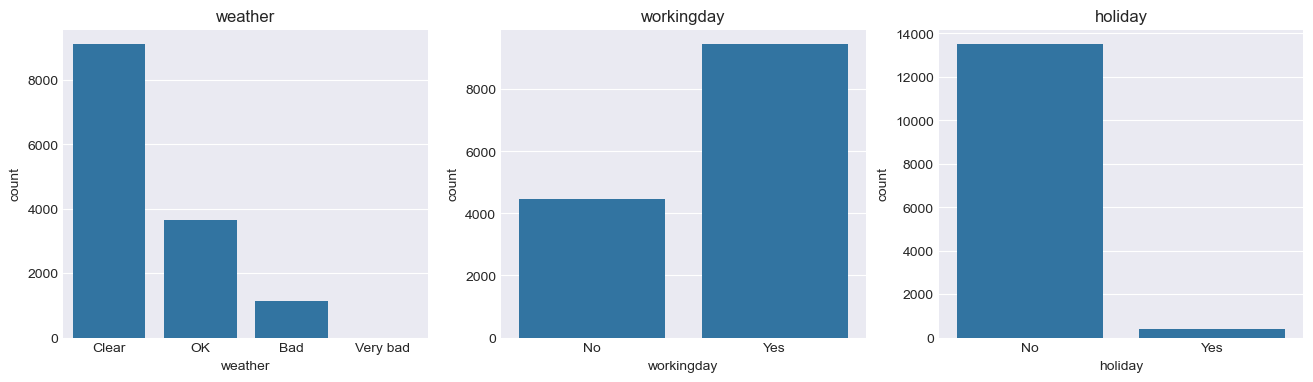

In [22]:
fig, axes = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(16, 4))
for column, ax in zip(categoricals[-3:], axes):
    sns.countplot(x=column, data=df_EDA, ax=ax)
    ax.set_title(column)

`holiday` is very unbalanced, there is no point in keeping it since its information is already included in `workingday`, we can drop it.

`workingday` is quite imbalanced but it should not be a problem for the model and it looks like it could be a good predictor. We will keep it as it is, we can just visualize its relationship with `count` first to confirm it.

In [23]:
categoricals.remove('holiday')

<AxesSubplot: xlabel='workingday', ylabel='count'>

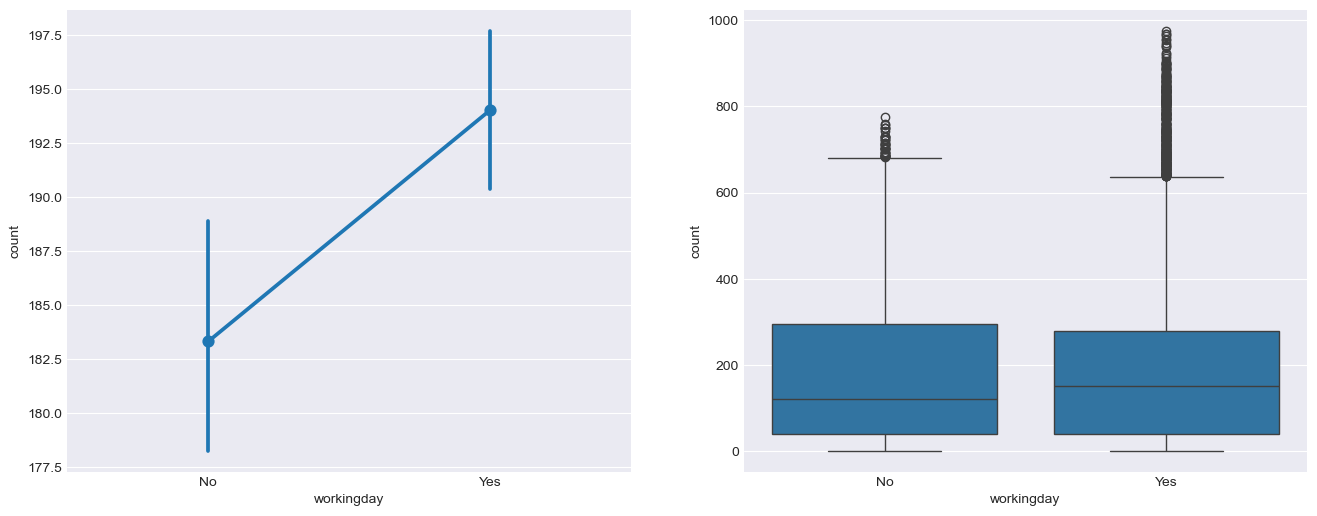

In [24]:
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(16, 6))
sns.pointplot(x='workingday', y='count', data=df_EDA, ax=axes[0])
sns.boxplot(x='workingday', y='count', data=df_EDA, ax=axes[1])

The pointplot really shows that `workingday` can be a good predictor.

`weather` is also very umbalanced, especially for the 4th category. Let's dig a little bit.

In [25]:
df_EDA.weather.value_counts()

Clear       9115
OK          3655
Bad         1131
Very bad       2
Name: weather, dtype: int64

<AxesSubplot: xlabel='weather', ylabel='count'>

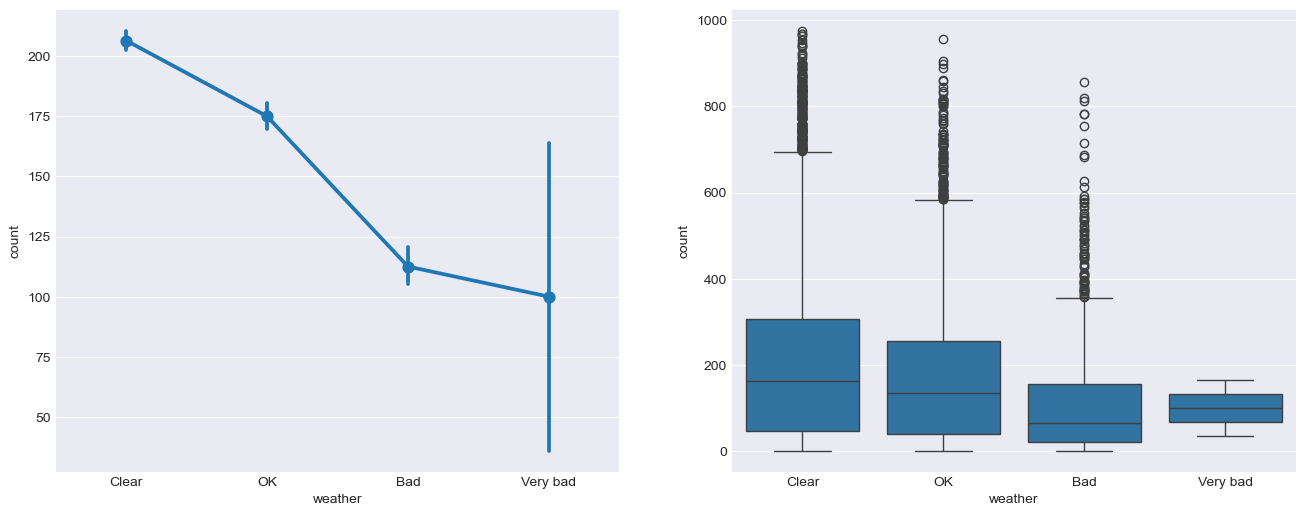

In [26]:
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(16, 6))
sns.pointplot(x='weather', y='count', data=df_EDA, ax=axes[0])
sns.boxplot(x='weather', y='count', data=df_EDA, ax=axes[1])

`weather` is definitely a good predictor, however ze should combine the very bad weather category with the bad one. There are only two rows with very bad weather and they seem to lie within the IQR of bad weather rows. After doing so, `weather` should prove very useful.

In [27]:
# if df_EDA where wheather is very bad put bad instead
df_EDA.loc[df_EDA.weather == 'Very bad', 'weather'] = 'Bad'
# remove category very bad from categorical variable weather def
df_EDA.weather = pd.Categorical(df_EDA.weather, categories=['Clear', 'OK', 'Bad'], ordered=True)
df_EDA.weather.value_counts()

Clear    9115
OK       3655
Bad      1133
Name: weather, dtype: int64

Ok, we can now go onto looking at the relationships between our categorical features and targets.

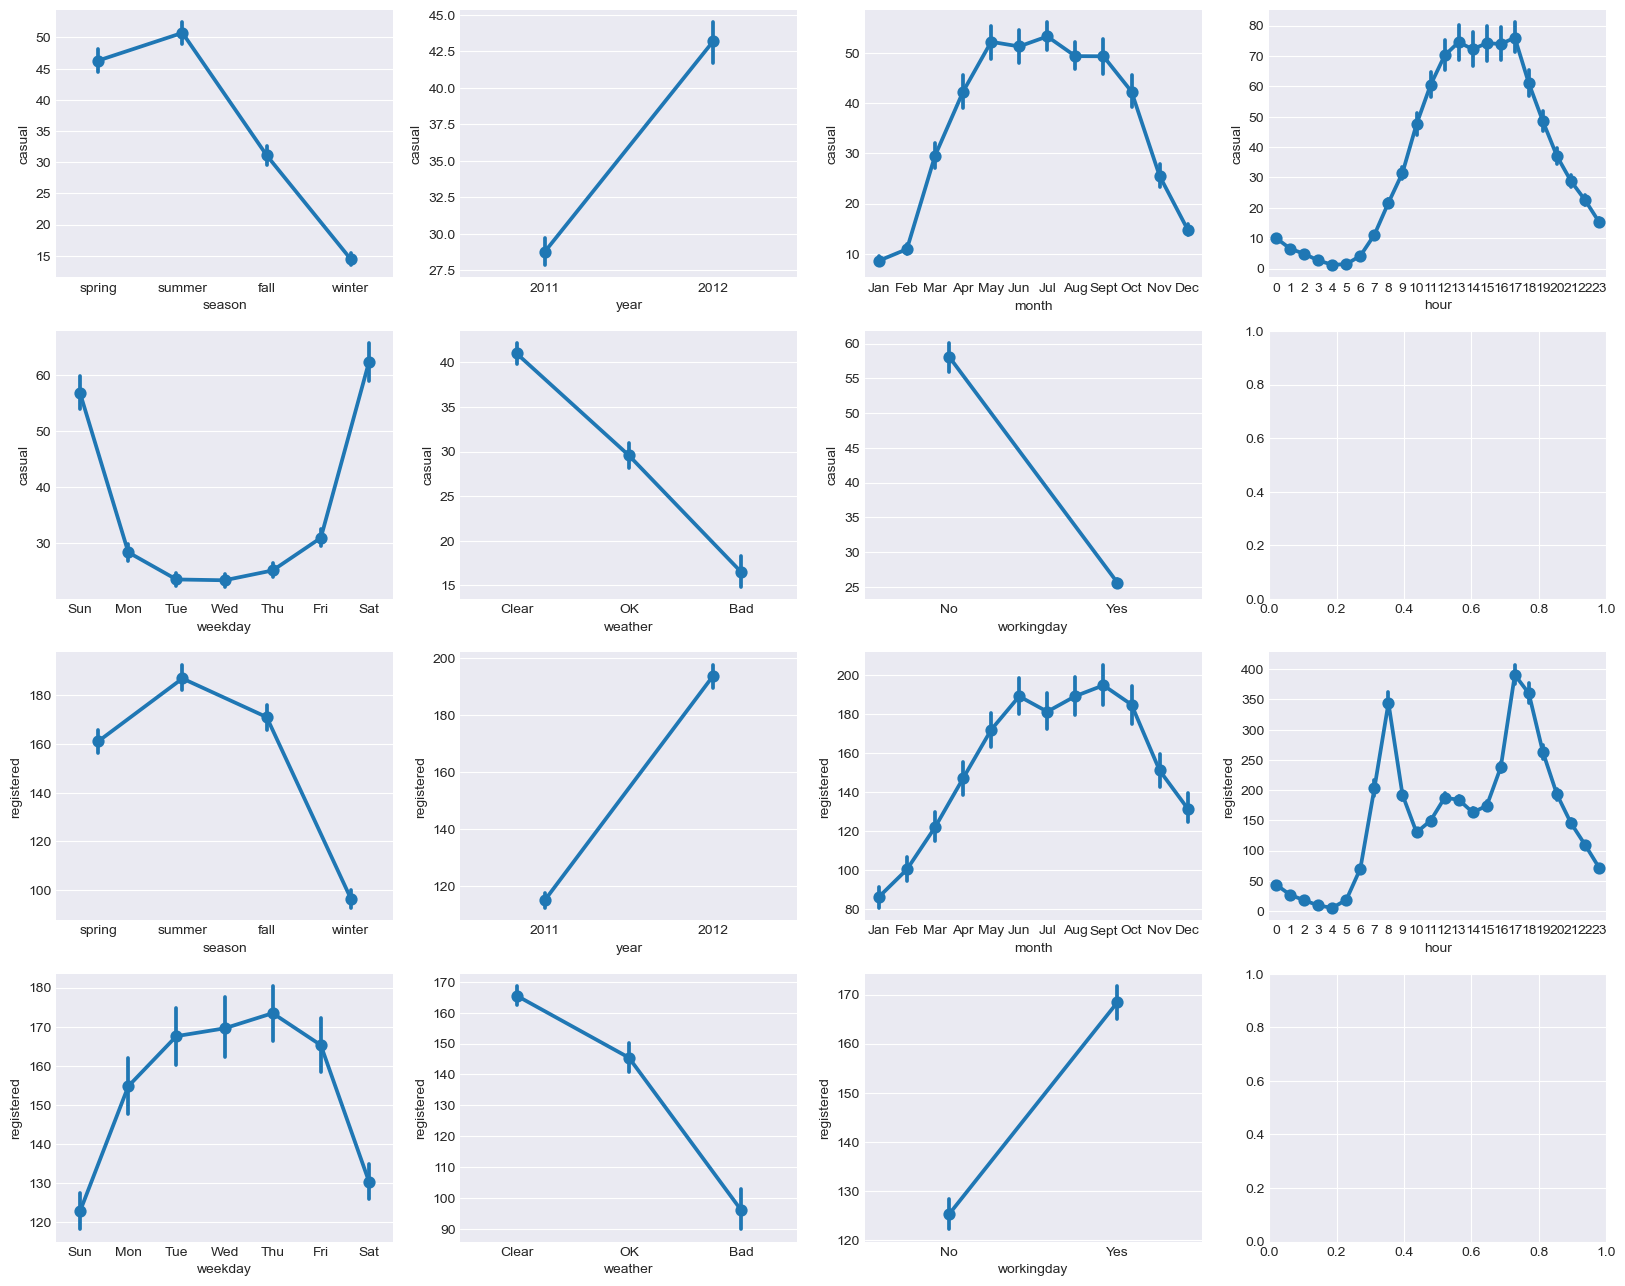

In [28]:
fig, axes = plt.subplots(4, 4, sharex=False, sharey=False, figsize=(20, 16))
axes = axes.flatten()
for i, column in enumerate(categoricals):
    sns.pointplot(x=column, y='casual', data=df_EDA, ax=axes[i])
    sns.pointplot(x=column, y='registered', data=df_EDA, ax=axes[i+8])

I did not plot the features against `count` as the plots are always very similar to those of `registered` and to avoid having too many charts.

First `season` is definitely related to the number of users, with an earlier deacrease in demand for casual users than for registered users. However There is a sharp decrease in the winter for both types of users.

`year` as said previosuly is definitely related to the number of users, with a clear increase in demand in 2012 compared to 2011 due to the growing popularity of the system.

`month` has a similar relationship for `casual` and `registered` users. Bars do not overlap in the increase and decrease period indicating well distinct periods of the year in terms of demand, however in the middle month of the year, demand is very similar (we could also see that to some extent in `season`). Using a cyclic variable for `month` will certainly be a good idea to limit the number of features.

`hour` is quite different for `casual` and `registered users`. For `casual` we have a peak in  demand in the afternoon with a prolongued period of high demand while `hour` is marked by two short and sharp demands spikes in the morning and in the evening (when people go to work and come back home) with a much lower demand in the meantime. This is not surprising as `casual` users are more likely to use the system for leisure and `registered` users for commuting. Given that, our intuition of using cyclic variables + dummies for peak periods (for regiistered users) and maybe a combination of these dummies with workingday might be a good idea.

`weekday` looks similar but completely inversed for `casual` and `registered` users. `casual` users use bikes a lot more in the weekends while `registered` users use them a lot more during the week. We also see this inversion in `workingday`. We will try to use a cyclic variable for `weekday` but I guess it will be discarded by the forward selection process as most of the effect of `weekday` is already captured by `workingday` (weekend or not). 

Finally, `weather` has a similar impact with both type of `users` except that `registered` users are more tolerant with "OK weather". 

Finnally there are some relationships between our categorical features and our numerical features, and between our categorical features that we have not explored. Some of them are obvious and some are not worth looking at because they just do not make sense. We will look at the most interesting ones to see if some combinations could prove useful or if we need to remove some of them.

We can start with season x weather.

<AxesSubplot: xlabel='season', ylabel='count'>

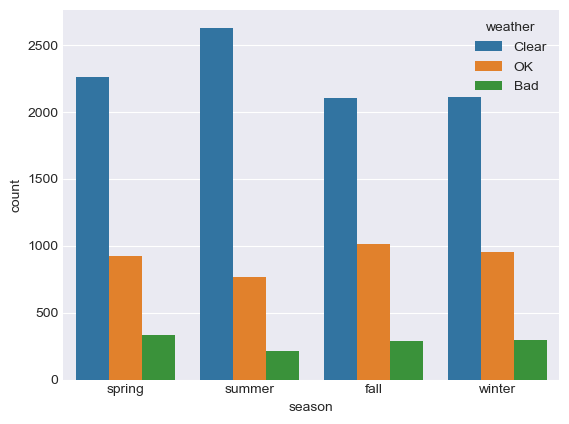

In [29]:
sns.countplot(x='season', hue='weather', data=df_EDA)

Interestingly, the relationship is not so obvious. We can see a higher ratio of clear weather in the summer but apart from that the two categories seem to be independant. Which is good as both seasons have predictive power. However we can expect season to be related to temperature. Let's check.

<AxesSubplot: xlabel='season', ylabel='temperature'>

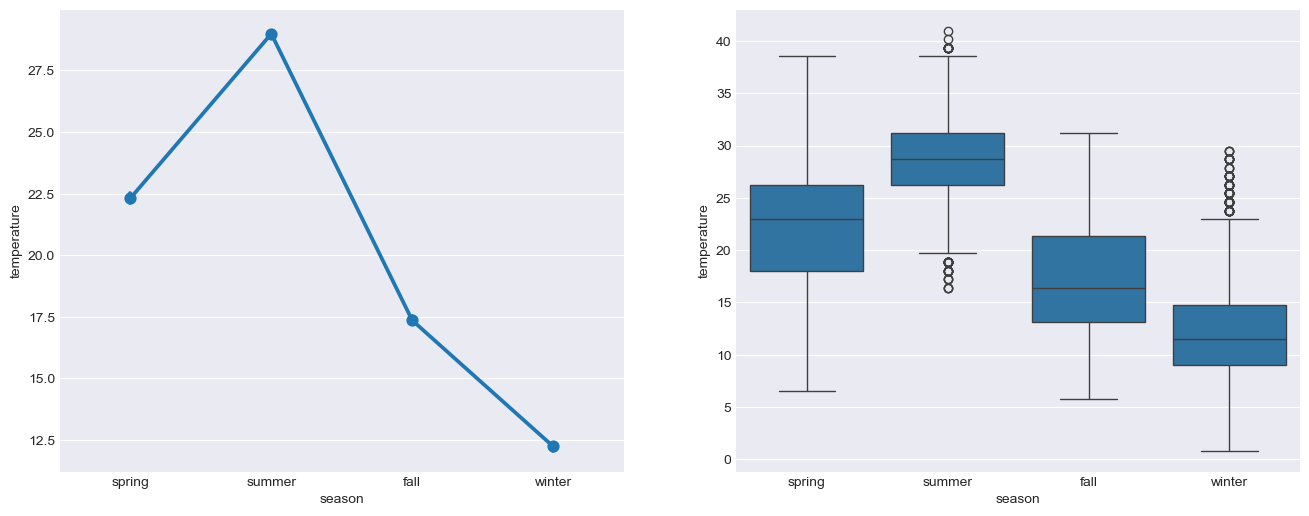

In [30]:
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(16, 6))
sns.pointplot(x='season', y='temperature', data=df_EDA, ax=axes[0])
sns.boxplot(x='season', y='temperature', data=df_EDA, ax=axes[1])

In fact, these two might be a bit duplicate but forward selection will keep the best one and might only keep one of the dummies of season for example.

<AxesSubplot: xlabel='season', ylabel='humidity'>

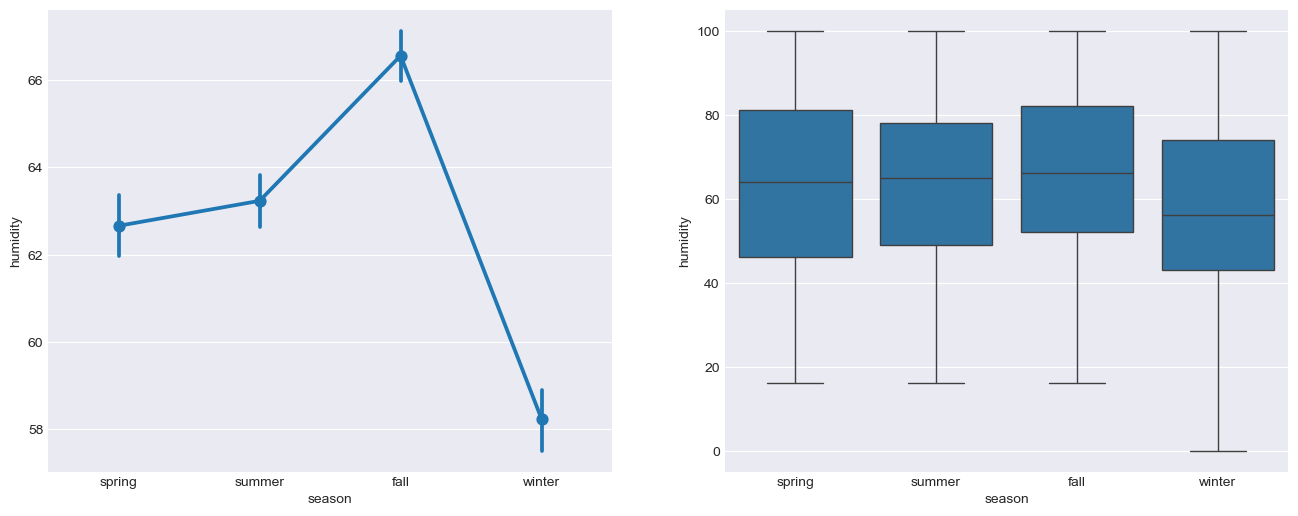

In [31]:
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(16, 6))
sns.pointplot(x='season', y='humidity', data=df_EDA, ax=axes[0])
sns.boxplot(x='season', y='humidity', data=df_EDA, ax=axes[1])

<AxesSubplot: xlabel='weather', ylabel='windspeed'>

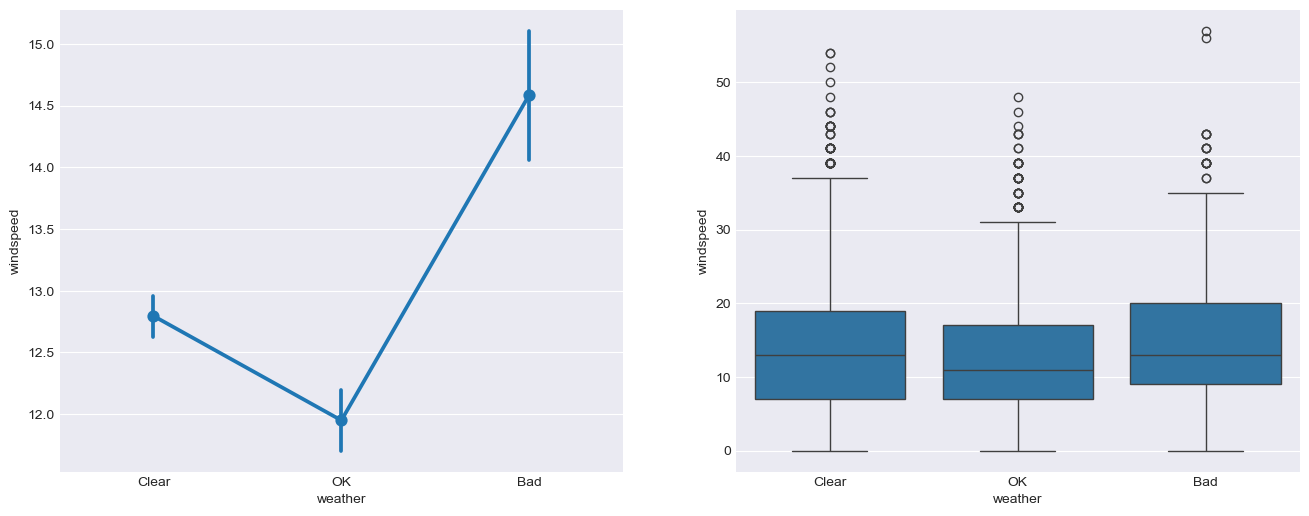

In [32]:
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(16, 6))
sns.pointplot(x='weather', y='windspeed', data=df_EDA, ax=axes[0])
sns.boxplot(x='weather', y='windspeed', data=df_EDA, ax=axes[1])

We also have these two not so surprising relationships but there is not much to say about it.

Let's go onto feature enginnering.

# 2.3 Feature engineering

Our goal is now to derive features from our existing features to potentially improve the performance of our model. First we have to create a new dataframe with our existing features encoded as needed.

We will start by droping `holiday` and `feel_temp`. For now we keep windspeed to see if we can find a transformation that makes it useful.

We also convert `season`, `workingday`, `year`, and `weather` to dummies (and drop the first column for each).

In [33]:
df_REG = df_EDA.copy().drop(['holiday', 'feel_temp'], axis=1)
# use month number instead of month name (for cyclic variables)
df_REG.month = train_set.month
# same for weekday
df_REG.weekday = train_set.weekday
# add dummies for season, year, workingday, weather
df_REG = pd.get_dummies(df_REG, columns=['season', 'year', 'workingday', 'weather'], drop_first=True)
df_REG.head()

,month,hour,weekday,temperature,humidity,windspeed,casual,registered,count,season_summer,season_fall,season_winter,year_2012,workingday_Yes,weather_OK,weather_Bad
date,,,,,,,,,,,,,,,,
2011-01-15 11:00:00,1,11,6,8.20,55.0,15.0013,18,54,72,0,0,1,0,0,0,0
2011-10-25 18:00:00,10,18,2,21.32,42.0,7.0015,65,453,518,0,1,0,0,1,0,0
2011-12-07 03:00:00,12,3,3,18.86,100.0,15.0013,0,3,3,0,1,0,0,1,0,1
2011-04-03 18:00:00,4,18,0,18.86,31.0,0.0000,71,101,172,0,0,0,0,0,1,0
2011-12-25 06:00:00,12,6,0,8.20,75.0,7.0015,0,1,1,0,0,1,0,0,0,0


Next, we create our cyclic variables for `hour`, `month`, `weekday`. 

In [34]:
df_REG['hour_sin'] = np.sin(2*np.pi*df_REG.hour.astype(int)/24)
df_REG['hour_cos'] = np.cos(2*np.pi*df_REG.hour.astype(int)/24)
df_REG['month_sin'] = np.sin(2*np.pi*df_REG.month.astype(int)/12)
df_REG['month_cos'] = np.cos(2*np.pi*df_REG.month.astype(int)/12)
df_REG['weekday_sin'] = np.sin(2*np.pi*df_REG.weekday.astype(int)/7)
df_REG['weekday_cos'] = np.cos(2*np.pi*df_REG.weekday.astype(int)/7)
df_REG.head()

,month,hour,weekday,temperature,humidity,windspeed,casual,registered,count,season_summer,...,year_2012,workingday_Yes,weather_OK,weather_Bad,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos
date,,,,,,,,,,,,,,,,,,,,,
2011-01-15 11:00:00,1,11,6,8.20,55.0,15.0013,18,54,72,0,...,0,0,0,0,0.258819,-9.659258e-01,5.000000e-01,0.866025,-0.781831,0.623490
2011-10-25 18:00:00,10,18,2,21.32,42.0,7.0015,65,453,518,0,...,0,1,0,0,-1.000000,-1.836970e-16,-8.660254e-01,0.500000,0.974928,-0.222521
2011-12-07 03:00:00,12,3,3,18.86,100.0,15.0013,0,3,3,0,...,0,1,0,1,0.707107,7.071068e-01,-2.449294e-16,1.000000,0.433884,-0.900969
2011-04-03 18:00:00,4,18,0,18.86,31.0,0.0000,71,101,172,0,...,0,0,1,0,-1.000000,-1.836970e-16,8.660254e-01,-0.500000,0.000000,1.000000
2011-12-25 06:00:00,12,6,0,8.20,75.0,7.0015,0,1,1,0,...,0,0,0,0,1.000000,6.123234e-17,-2.449294e-16,1.000000,0.000000,1.000000


We also create dummies for peak periods of `hour` and combine them with `workingday`.

<AxesSubplot: xlabel='hour', ylabel='registered'>

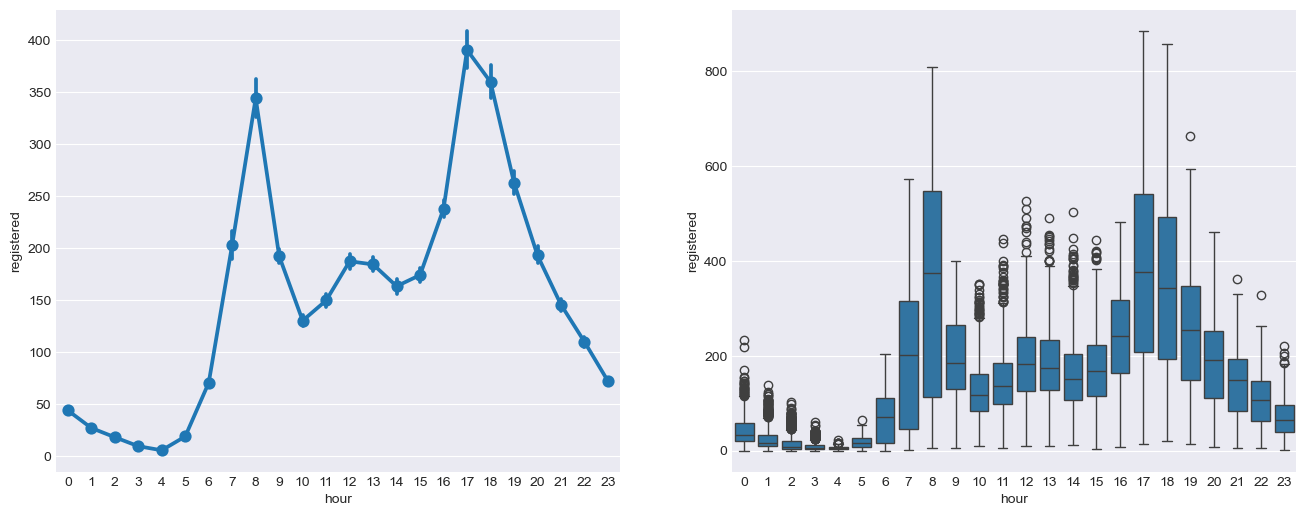

In [35]:
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(16, 6))
sns.pointplot(x='hour', y='registered', data=df_REG, ax = axes[0])
sns.boxplot(x='hour', y='registered', data=df_REG, ax = axes[1])

We can see from the pointplot that the biggest peak hours are 8h, 17h and 18h so we will create a `is_peak_time` dummy for these hours. However the boxplot suggest that we could include 7h, 9h and 16h, 19h as they also have high median and it makes sense that most of work commuting happens during these hours. We will create a second dummy and see which one gets picked by forward selection.

In [36]:
df_REG['is_peak_time'] = df_REG.hour.isin([8,17,18]).astype(int)
df_REG['is_larger_peak_time'] = df_REG.hour.isin([7,8,9,16,17,18,19]).astype(int)

We can combine our dummies with with `workingday` and remove our original `hour`, `month` and `weekday` features as we do not need them anymore in that form.

In [37]:
#combine is_peak_time with workingday in new feature
df_REG['is_peak_work_commute'] = df_REG.is_peak_time*df_REG.workingday_Yes
df_REG['is_work_commute'] = df_REG.is_larger_peak_time*df_REG.workingday_Yes
df_REG.drop(['hour','month','weekday'], axis=1, inplace=True)
df_REG.head()

,temperature,humidity,windspeed,casual,registered,count,season_summer,season_fall,season_winter,year_2012,...,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,is_peak_time,is_larger_peak_time,is_peak_work_commute,is_work_commute
date,,,,,,,,,,,,,,,,,,,,,
2011-01-15 11:00:00,8.20,55.0,15.0013,18,54,72,0,0,1,0,...,0.258819,-9.659258e-01,5.000000e-01,0.866025,-0.781831,0.623490,0,0,0,0
2011-10-25 18:00:00,21.32,42.0,7.0015,65,453,518,0,1,0,0,...,-1.000000,-1.836970e-16,-8.660254e-01,0.500000,0.974928,-0.222521,1,1,1,1
2011-12-07 03:00:00,18.86,100.0,15.0013,0,3,3,0,1,0,0,...,0.707107,7.071068e-01,-2.449294e-16,1.000000,0.433884,-0.900969,0,0,0,0
2011-04-03 18:00:00,18.86,31.0,0.0000,71,101,172,0,0,0,0,...,-1.000000,-1.836970e-16,8.660254e-01,-0.500000,0.000000,1.000000,1,1,0,0
2011-12-25 06:00:00,8.20,75.0,7.0015,0,1,1,0,0,1,0,...,1.000000,6.123234e-17,-2.449294e-16,1.000000,0.000000,1.000000,0,0,0,0


Now, we can start experimenting with functions of numerical variables and add the most promising to our dataframe.

It is hard to see any relationships by plotting our targets against our numerical variables, so we will compute many functions of our 3 remaining numerical features and look at the best correlations to the targets to decide wether they are worth trying out in forward selection.

**UPDATE : See note on feature engineering at the end of the next section**

In [38]:
df_candidates = df_REG[["casual", "registered", "count"]].copy()
df_candidates["temperature"] = df_REG["temperature"]
df_candidates["temp_squared"] = df_REG["temperature"]**2
df_candidates["temp_cubed"] = df_REG["temperature"]**3
df_candidates["temp_p4"] = df_REG["temperature"]**4
df_candidates["temp_p5"] = df_REG["temperature"]**5
df_candidates["temp_log"] = np.log(df_REG["temperature"])
df_candidates["temp_exp"] = np.exp(df_REG["temperature"])
df_candidates["temp_sin"] = np.sin(df_REG["temperature"])
df_candidates["temp_cos"] = np.cos(df_REG["temperature"])
df_candidates["temp_tan"] = np.tan(df_REG["temperature"])

# same for humidity
df_candidates["humidity"] = df_REG["humidity"]
df_candidates["hum_squared"] = df_REG["humidity"]**2
df_candidates["hum_cubed"] = df_REG["humidity"]**3
df_candidates["hum_p4"] = df_REG["humidity"]**4
df_candidates["hum_p5"] = df_REG["humidity"]**5
df_candidates["hum_log"] = np.log(df_REG["humidity"])
df_candidates["hum_exp"] = np.exp(df_REG["humidity"])
df_candidates["hum_sin"] = np.sin(df_REG["humidity"])
df_candidates["hum_cos"] = np.cos(df_REG["humidity"])
df_candidates["hum_tan"] = np.tan(df_REG["humidity"])

# same for windspeed
df_candidates["windspeed"] = df_REG["windspeed"]
df_candidates["wind_squared"] = df_REG["windspeed"]**2
df_candidates["wind_cubed"] = df_REG["windspeed"]**3
df_candidates["wind_p4"] = df_REG["windspeed"]**4
df_candidates["wind_p5"] = df_REG["windspeed"]**5
df_candidates["wind_log"] = np.log(df_REG["windspeed"])
df_candidates["wind_exp"] = np.exp(df_REG["windspeed"])
df_candidates["wind_sin"] = np.sin(df_REG["windspeed"])
df_candidates["wind_cos"] = np.cos(df_REG["windspeed"])
df_candidates["wind_tan"] = np.tan(df_REG["windspeed"])

df_candidates.head()

/Users/matteomenager/anaconda3/envs/data-mining/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/matteomenager/anaconda3/envs/data-mining/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,casual,registered,count,temperature,temp_squared,temp_cubed,temp_p4,temp_p5,temp_log,temp_exp,...,windspeed,wind_squared,wind_cubed,wind_p4,wind_p5,wind_log,wind_exp,wind_sin,wind_cos,wind_tan
date,,,,,,,,,,,,,,,,,,,,,
2011-01-15 11:00:00,18,54,72,8.20,67.2400,551.368000,4521.217600,3.707398e+04,2.104134,3.640950e+03,...,15.0013,225.039002,3375.877576,50642.552282,759704.119542,2.708137,3.273270e+06,0.649300,-0.760533,-0.853743
2011-10-25 18:00:00,65,453,518,21.32,454.5424,9690.843968,206608.793398,4.404899e+06,3.059646,1.816178e+09,...,7.0015,49.021002,343.220547,2403.058662,16825.015219,1.946124,1.098279e+03,0.658117,0.752916,0.874091
2011-12-07 03:00:00,0,3,3,18.86,355.6996,6708.494456,126522.205440,2.386209e+06,2.937043,1.551651e+08,...,15.0013,225.039002,3375.877576,50642.552282,759704.119542,2.708137,3.273270e+06,0.649300,-0.760533,-0.853743
2011-04-03 18:00:00,71,101,172,18.86,355.6996,6708.494456,126522.205440,2.386209e+06,2.937043,1.551651e+08,...,0.0000,0.000000,0.000000,0.000000,0.000000,-inf,1.000000e+00,0.000000,1.000000,0.000000
2011-12-25 06:00:00,0,1,1,8.20,67.2400,551.368000,4521.217600,3.707398e+04,2.104134,3.640950e+03,...,7.0015,49.021002,343.220547,2403.058662,16825.015219,1.946124,1.098279e+03,0.658117,0.752916,0.874091


In [39]:
candidates_corr = df_candidates.corr()

In [40]:
# for temperature, humidity and windspeed 
    # for casual, registered, count
        # get best 3 correlated features to target among derived functions including original feature (absolute value) with the coefficient 
derived_features_names = {
    "temperature":["temperature", "temp_squared", "temp_cubed", "temp_p4", "temp_p5", "temp_log", "temp_exp", "temp_sin", "temp_cos", "temp_tan"],
    "humidity":["humidity", "hum_squared", "hum_cubed", "hum_p4", "hum_p5", "hum_log", "hum_exp", "hum_sin", "hum_cos", "hum_tan"],
    "windspeed":["windspeed", "wind_squared", "wind_cubed", "wind_p4", "wind_p5", "wind_log", "wind_exp", "wind_sin", "wind_cos", "wind_tan"]
}
for feature in ["temperature", "humidity", "windspeed"] :
    print(f"\n---- FEATURE : {feature} ----")
    for target in ["casual", "registered", "count"] :
        print(f"\nTARGET : {target} ")
        corr = candidates_corr[target].copy()
        corr = corr[derived_features_names[feature]]
        corr = corr.sort_values(ascending=False, key=lambda col: np.abs(col))
        print(corr.head(5))


---- FEATURE : temperature ----

TARGET : casual 
temp_squared    0.462418
temperature     0.459930
temp_cubed      0.450793
temp_p4         0.431378
temp_log        0.425322
Name: casual, dtype: float64

TARGET : registered 
temperature     0.333426
temp_squared    0.325220
temp_log        0.323712
temp_cubed      0.310913
temp_p4         0.293714
Name: registered, dtype: float64

TARGET : count 
temperature     0.403476
temp_squared    0.397307
temp_log        0.385944
temp_cubed      0.382204
temp_p4         0.362565
Name: count, dtype: float64

---- FEATURE : humidity ----

TARGET : casual 
humidity      -0.345771
hum_log       -0.344969
hum_squared   -0.342615
hum_cubed     -0.331511
hum_p4        -0.317717
Name: casual, dtype: float64

TARGET : registered 
hum_squared   -0.278944
humidity      -0.276011
hum_cubed     -0.274665
hum_log       -0.272039
hum_p4        -0.267434
Name: registered, dtype: float64

TARGET : count 
hum_squared   -0.326063
humidity      -0.324475
hum_log 

First, we can see that the computed features do not provide much improvement for `windspeed`. In addition we saw earlier that `windspeed` had a relationship with `weather` so keeping it won't help the model. We can drop it (and its associated correlated features).

For `humidity` and `temperature` we can see that the computed features do not provide much improvement (only very small increases in correlation for some combinations), we will only keep the original features so we do not loose in model interpretability.

In [41]:
df_REG.drop('windspeed', axis=1, inplace=True)

Let's plot a correlation heatmap of uour final set of features.

In [42]:
corr= df_REG.corr()

<AxesSubplot: >

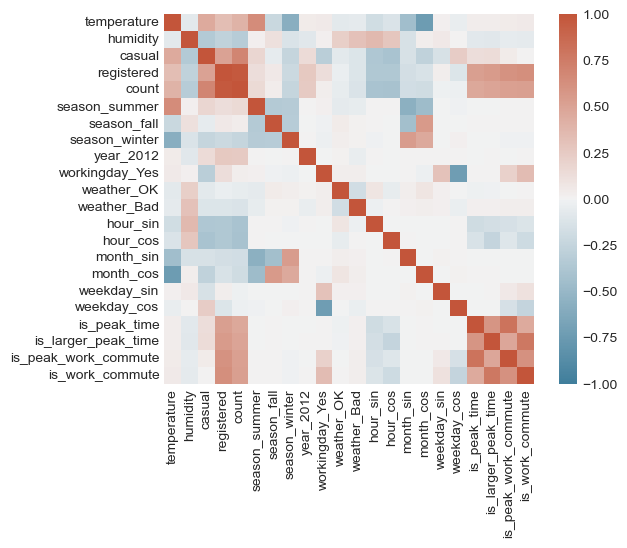

In [43]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, square=True, vmin=-1, vmax=1, cmap=cmap)

We can see that we definitely have some meaningful correlations with our target. We also have inter-features correlations but this is not a problem as we will use forward selection to select the best combination of features based on results on the validation set (10-fold cross-validation). We will make sure that our selected features are not too correlated with each other.

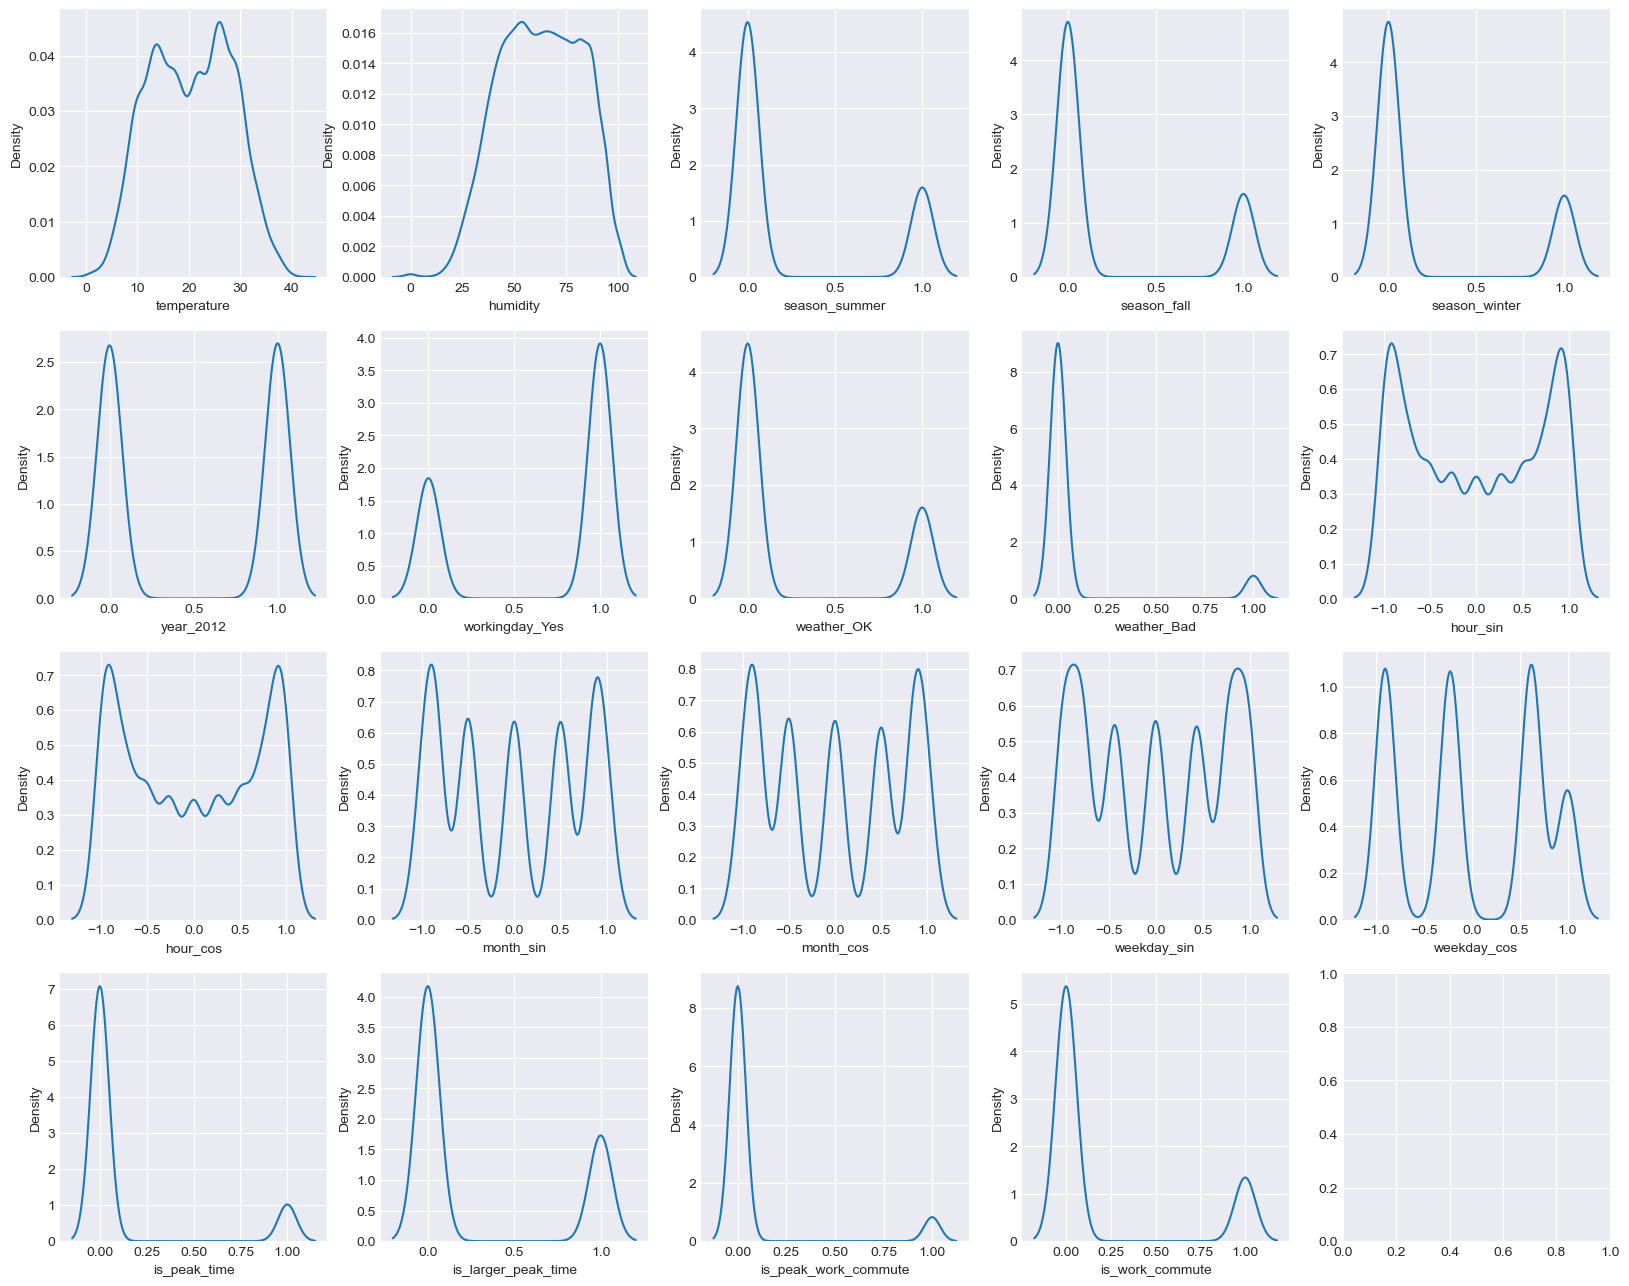

In [44]:
fig, axes = plt.subplots(4, 5, sharex=False, sharey=False, figsize=(20, 16))
axes=axes.flatten()
for index, column in enumerate(df_REG.drop(['casual', 'registered', 'count'], axis=1).columns):
    sns.kdeplot(df_REG[column], ax=axes[index])

We just take a final look at the distributions of our features. None of the features has big outliers problems so we do not need to apply a robust scaling. The only potential issue is that we have some very unbalanced category this is normal as they are dummies based on specific times of the day, and they should prove very useful so we ar egood to go.

In [45]:
df_REG.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13903 entries, 2011-01-15 11:00:00 to 2012-10-25 08:00:00
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   temperature           13903 non-null  float64
 1   humidity              13903 non-null  float64
 2   casual                13903 non-null  int64  
 3   registered            13903 non-null  int64  
 4   count                 13903 non-null  int64  
 5   season_summer         13903 non-null  uint8  
 6   season_fall           13903 non-null  uint8  
 7   season_winter         13903 non-null  uint8  
 8   year_2012             13903 non-null  uint8  
 9   workingday_Yes        13903 non-null  uint8  
 10  weather_OK            13903 non-null  uint8  
 11  weather_Bad           13903 non-null  uint8  
 12  hour_sin              13903 non-null  float64
 13  hour_cos              13903 non-null  float64
 14  month_sin             13903 non-nul

Finally, all our features are numerical now as we can see above. We can now start building our model.

# Task 3: Using a forward selection approach, build a regression model that offers the best performance

The goal is now to find the best combination of features among the ones we encoded and/or created. We have a total of 19 features and to keep our model simple and prevent overfitting, having a model with no more than 10 features would be ideal. 

In order to reduce the number of features, we could use these 3 strategies : 
- Forward selection
- Regularization (Lasso or Ridge)
- PCA

We will build 3 different models (one for each target) using the forward selection approach. We will then use a normalized metric to see which target is easier to predict.  

At the end of this section, I will try to use regularization or PCA (for the easiest target to predict only) instead to see which approach gives us the best results.

The first step is to create a function for forward selection. This function starts from the simpliest model (constant) and adds the best feature (lowest RMSE) until RMSE starts to increase. At each step, a Linear Regression model (OLS) is fitted using K-fold cross-validation. The function returns the list of features selected by forward selection and the average RMSE (cross-validation) of the model for each feature added.

In [46]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def forward_selection_regression(features, target, cv=10):
    model = LinearRegression(fit_intercept=False)
    
    remaining_features = list(features.columns)
    selected_features = []
    model_error = []
    
    # compute the error for the smallest model with only a constant fitted (no need for cross validation for that)
    X = pd.DataFrame({'constant':np.ones(len(features))})
    X_train, X_val, y_train, y_val = train_test_split(X, target, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    Y_pred = model.predict(X_val)
    model_error.append(mean_squared_error(y_val, Y_pred, squared=False))
    
    model = LinearRegression(fit_intercept=True)
    last_min_error_feature = None
    last_min_error = None
    while last_min_error == None and len(remaining_features) > 0:
        #print(f"\n---{len(selected_features)} features selected for now---")
        for feature in remaining_features:
            X = features[selected_features + [feature]]
            cv_score = - cross_val_score(model, X, target, cv=cv, scoring='neg_root_mean_squared_error').mean()
            #print(f"Trying {feature} - CV score: {cv_score}")
            if last_min_error is None or cv_score < last_min_error:
                last_min_error = cv_score
                last_min_error_feature = feature
        if last_min_error < model_error[-1]:
            #print(f"Adding {last_min_error_feature} with error {last_min_error}")
            selected_features.append(last_min_error_feature)
            remaining_features.remove(last_min_error_feature)
            model_error.append(last_min_error)
            last_min_error = None
            last_min_error_feature = None
            
    selected_features = ["constant"] + selected_features
    return selected_features, model_error
    

We will create a helper function to make our life easier when looking at the results.

In [47]:
def show_forward_selection_results(selected_features, model_error):
    # create a dataframe with selected features, their error and percentage decrease from previous one
    df = pd.DataFrame({'feature':selected_features, 'error':model_error})
    # add column with percentage decrease from previous error, put 0 for first feature
    df['pct_error_decrease'] = df.error.pct_change().fillna(0)
    return df


Finally, we will apply the same transformations to the test set than we applied on the training set for regression (`df_REG`). This will allow us to evaluate our models on the test set.

*Note that we will directly apply these transformation on the `test_set` dataframe and drop the columns we have dropped in `df_REG` as we have dropped them for good reasons and we will use the same columns for forward selection in the context of classification since the two algorithm we will use take numerical features as input like linear regression. For classification we might need to apply some transformation on our numeric features, but that does not require keeping the original features. The reason why I kept `train_set` unchanged countrary to `test_set` is to be able to look into the data (EDA) afterwards, but we only do this on the training set so there is no need to keep the `test_set` unchanged.*

In [48]:
# descale temperature and humidity 
test_set.temperature = test_set.temperature * 41
test_set.humidity = test_set.humidity * 100

# seasons
test_set['season_winter'] = (test_set.season == 1).astype(int)
test_set['season_summer'] = (test_set.season == 3).astype(int)
test_set['season_fall'] = (test_set.season == 4).astype(int)

# year_2012
test_set['year_2012'] = test_set.year

# workingday_Yes
test_set['workingday_Yes'] = test_set.workingday

# weather
test_set['weather_OK'] = (test_set.weather == 2).astype(int)
test_set['weather_Bad'] = test_set.weather.isin([3, 4]).astype(int)

# hour_sin, hour_cos
test_set['hour_sin'] = np.sin(2*np.pi*test_set.hour/24)
test_set['hour_cos'] = np.cos(2*np.pi*test_set.hour/24)

# month_sin, month_cos
test_set['month_sin'] = np.sin(2*np.pi*test_set.month/12)
test_set['month_cos'] = np.cos(2*np.pi*test_set.month/12)

# weekday_sin, weekday_cos
test_set['weekday_sin'] = np.sin(2*np.pi*test_set.weekday/7)
test_set['weekday_cos'] = np.cos(2*np.pi*test_set.weekday/7)

# peak time
test_set['is_peak_time'] = test_set.hour.isin([8,17,18]).astype(int)
test_set['is_larger_peak_time'] = test_set.hour.isin([7,8,9,16,17,18,19]).astype(int)

# work commute
test_set['is_work_commute'] = test_set.is_larger_peak_time * test_set.workingday
test_set['is_peak_work_commute'] = test_set.is_peak_time * test_set.workingday

# keep same columns as in df_REG
test_set = test_set[['temperature', 'humidity', 'casual', 'registered', 'count',
       'season_summer', 'season_fall', 'season_winter', 'year_2012',
       'workingday_Yes', 'weather_OK', 'weather_Bad', 'hour_sin', 'hour_cos',
       'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos', 'is_peak_time',
       'is_larger_peak_time', 'is_peak_work_commute', 'is_work_commute']]

In [49]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3476 entries, 2012-06-23 19:00:00 to 2011-12-13 19:00:00
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   temperature           3476 non-null   float64
 1   humidity              3476 non-null   float64
 2   casual                3476 non-null   int64  
 3   registered            3476 non-null   int64  
 4   count                 3476 non-null   int64  
 5   season_summer         3476 non-null   int64  
 6   season_fall           3476 non-null   int64  
 7   season_winter         3476 non-null   int64  
 8   year_2012             3476 non-null   int64  
 9   workingday_Yes        3476 non-null   int64  
 10  weather_OK            3476 non-null   int64  
 11  weather_Bad           3476 non-null   int64  
 12  hour_sin              3476 non-null   float64
 13  hour_cos              3476 non-null   float64
 14  month_sin             3476 non-null 

`test_set` is now in the same format as `df_REG` so we can use it to evaluate our models.

We can now use forward approach to find the best features for our model. 

---------

**Let's start with `casual` as a target.**

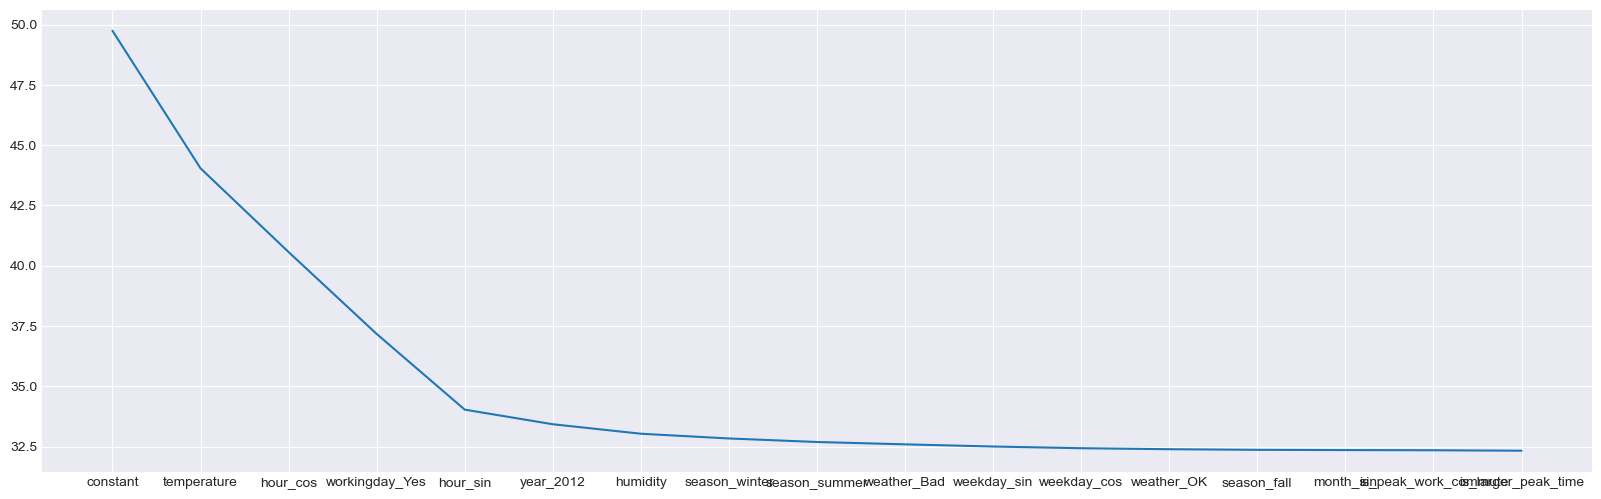

In [50]:
X = df_REG.drop(['casual', 'registered', 'count'], axis=1)
selected_features, model_error = forward_selection_regression(X, df_REG['casual'], cv=10)
fig = plt.figure(figsize=(20, 6))
plt.plot(selected_features, model_error)

In [51]:
show_forward_selection_results(selected_features, model_error)

,feature,error,pct_error_decrease
0,constant,49.742015,0.000000
1,temperature,44.037245,-0.114687
2,hour_cos,40.565053,-0.078847
3,workingday_Yes,37.169720,-0.083701
4,hour_sin,34.030003,-0.084470
5,year_2012,33.423951,-0.017809
6,humidity,33.030558,-0.011770
7,season_winter,32.834051,-0.005949
8,season_summer,32.687807,-0.004454
9,weather_Bad,32.590342,-0.002982


Above are the 16 features (+ constant term) kept by the model. 16 is a lot, and some of them are similar. We can see in the plot that RMSE starts to flatten out at some point after 4-8 features (elbow at 4, almost flat from 8). A very simple model with 4 features does a pretty good job with an RMSE of 34. After that, the decrease in RMSE are much smaller but we could potentially keep up to 8 features (RMSE of 32). However, I think that having a simplier model is a very good thing, so a good compromise could be to keep the first 6 features as these two ones still provide a >1% decrease in RMSE and make sense to include in the model while the 2 following could be a bit redundant.

In conclusion, we will keep the 6 following features for predicting `casual` : `temperature`, `hour_cos`, `workingday_Yes`, `hour_sin`, `year_2012`, `humidity`. 

We can rebuild the model with the entire training data (no cross-validation) and only the selected features to compute a final RMSE on the **test set** that we will normalize to compare with the other targets.

In [52]:
final_casual_lin_reg_model = LinearRegression(fit_intercept=True)
casual_kept_features = ['temperature', 'hour_cos', 'workingday_Yes', 'hour_sin', 'year_2012', 'humidity']
final_casual_lin_reg_model.fit(df_REG[casual_kept_features], df_REG['casual'])

LinearRegression()

Now we can evaluate our model on the test set and take a look at the residuals.

In [53]:
casual_test_pred = final_casual_lin_reg_model.predict(test_set[casual_kept_features])
casual_RMSE = mean_squared_error(test_set['casual'], casual_test_pred, squared=False)
casual_RMSE_normalized = casual_RMSE / test_set['casual'].mean()
print(f"RMSE: {casual_RMSE}, normalized RMSE: {casual_RMSE_normalized}")

RMSE: 31.896845333168688, normalized RMSE: 0.9279975424193508


<AxesSubplot: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

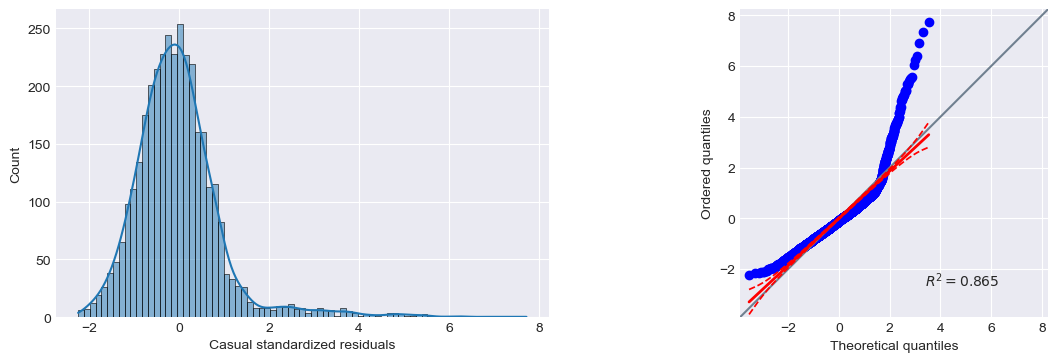

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
casual_residuals = test_set['casual'] - casual_test_pred
casual_standardized_residuals = casual_residuals / casual_residuals.std()
sns.histplot(casual_standardized_residuals, kde=True, ax=axes[0])
axes[0].set_xlabel('Casual standardized residuals')
pg.qqplot(casual_standardized_residuals, dist='norm', ax=axes[1])

Our residuals for `casual` are not really good but are not desastrous either. On the posititive side of things, they are centered on zero and are bell-shaped, however they are right skewed. We can note that the count for the tail is quite low though and that $R^2$ is not that bad. I wonder why this is, maybe there is something I have not accounted for in my model, more feature engineering might be needed for `casual`. 

*I tried using only 4 features and using 8 features instead of 6 but the results where not better.*

--------

**We can now do the same for `registered`.**

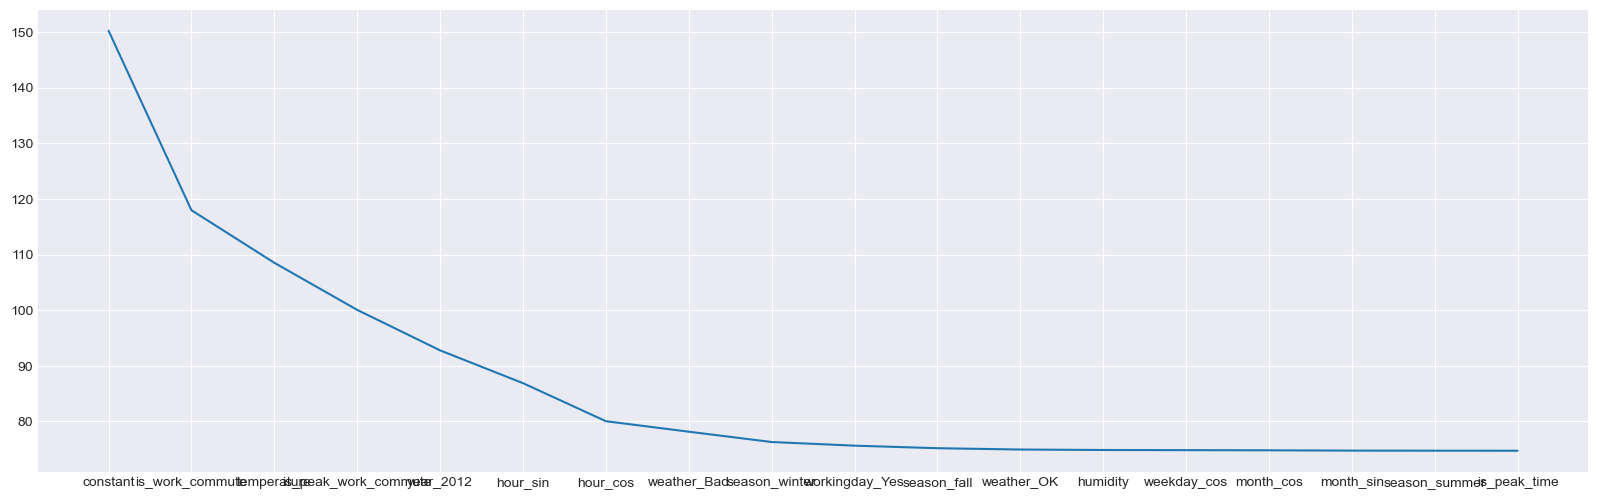

In [55]:
selected_features, model_error = forward_selection_regression(X, df_REG['registered'], cv=10)
fig = plt.figure(figsize=(20, 6))
plt.plot(selected_features, model_error)

In [56]:
show_forward_selection_results(selected_features, model_error)

,feature,error,pct_error_decrease
0,constant,150.242194,0.000000
1,is_work_commute,117.976007,-0.214761
2,temperature,108.523726,-0.080120
3,is_peak_work_commute,100.057310,-0.078014
4,year_2012,92.777210,-0.072759
5,hour_sin,86.884853,-0.063511
6,hour_cos,80.045734,-0.078715
7,weather_Bad,78.160688,-0.023550
8,season_winter,76.303404,-0.023762
9,workingday_Yes,75.649903,-0.008565


For `registered`, it makes sense to keep 8 features as the decrease in RMSE is still significant until this point and the first 8 features selected make sense. We will keep the following features : 
- `is_work_commute`
- `temperature`
- `is_peak_work_commute`
- `year_2012`
- `hour_sin`
- `hour_cos`
- `weather_Bad`
- `season_winter`

We can rebuild the model with the entire training data (no cross-validation) and only the selected features to compute a final RMSE on the **test set** that we will normalize to compare with the other targets.

In [57]:
final_registered_lin_reg_model = LinearRegression(fit_intercept=True)
registered_kept_features = ['is_work_commute', 'temperature', 'is_peak_work_commute', 'year_2012', 'hour_sin', 'hour_cos', 'weather_Bad', 'season_winter']
final_registered_lin_reg_model.fit(df_REG[registered_kept_features], df_REG['registered'])

LinearRegression()

Now we can evaluate our model on the test set and take a look at the residuals.

In [58]:
registered_test_pred = final_registered_lin_reg_model.predict(test_set[registered_kept_features])
registered_RMSE = mean_squared_error(test_set['registered'], registered_test_pred, squared=False)
registered_RMSE_normalized = registered_RMSE / test_set['registered'].mean()
print(f"RMSE: {registered_RMSE}, normalized RMSE: {registered_RMSE_normalized}")

RMSE: 73.98304854926214, normalized RMSE: 0.49113858932647425


<AxesSubplot: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

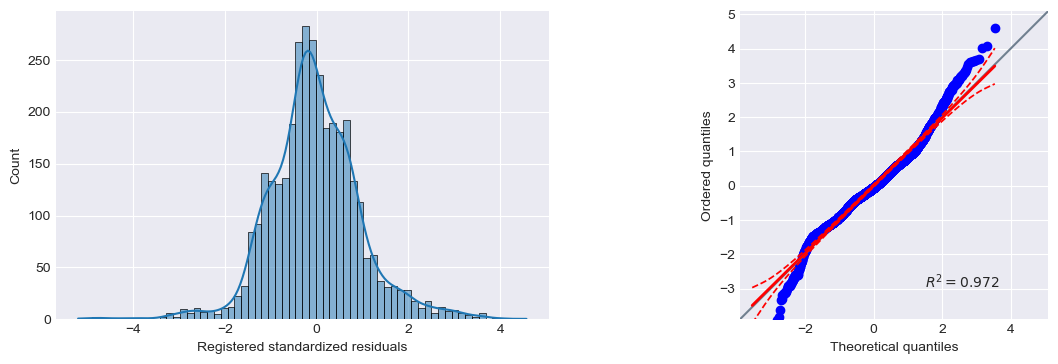

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(14,4))
registered_residuals = test_set['registered'] - registered_test_pred
registered_standardized_residuals = registered_residuals / registered_residuals.std()
sns.histplot(registered_standardized_residuals, kde=True, ax=axes[0])
axes[0].set_xlabel('Registered standardized residuals')
pg.qqplot(registered_standardized_residuals, dist='norm', ax=axes[1])

The residuals are looking much better for `registered` than for `casual` and normalized RMSE is 45% lower as well, our model is doing good for `registered`.

---------
    
**Finally, we can do the same for `count`.**

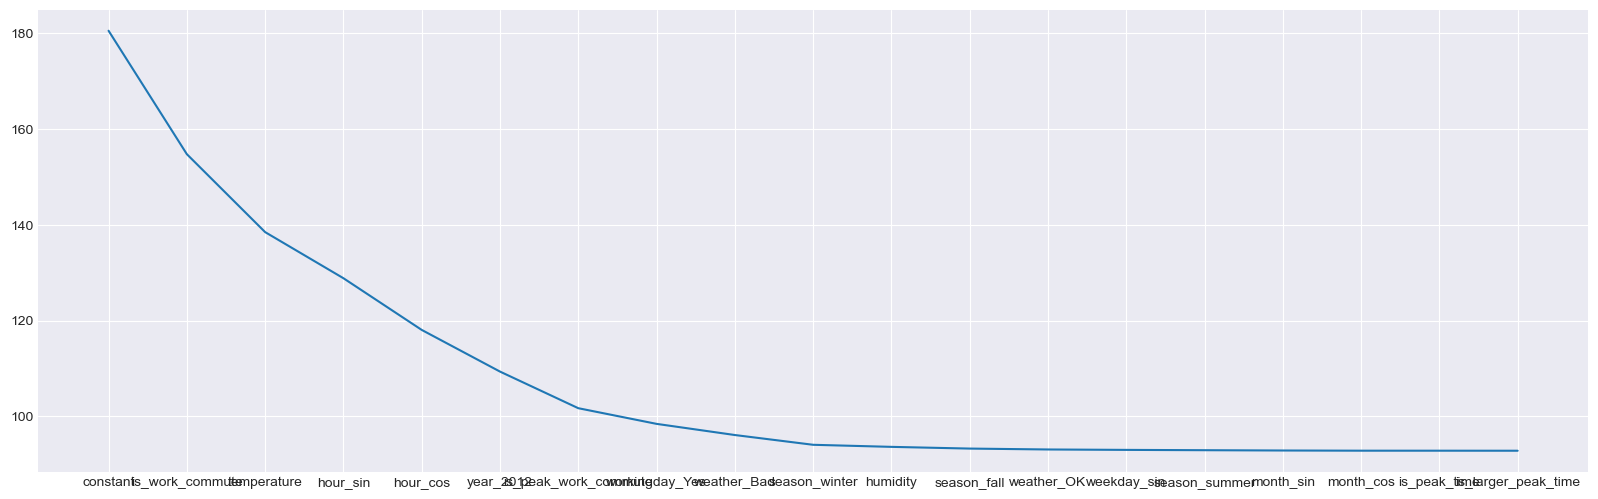

In [60]:
selected_features, model_error = forward_selection_regression(X, df_REG['count'], cv=10)
fig = plt.figure(figsize=(20, 6))
plt.plot(selected_features, model_error)

In [61]:
show_forward_selection_results(selected_features, model_error)

,feature,error,pct_error_decrease
0,constant,180.564164,0.000000
1,is_work_commute,154.774669,-0.142827
2,temperature,138.491160,-0.105208
3,hour_sin,128.857641,-0.069561
4,hour_cos,118.059655,-0.083798
5,year_2012,109.351262,-0.073763
6,is_peak_work_commute,101.701677,-0.069954
7,workingday_Yes,98.427288,-0.032196
8,weather_Bad,96.096673,-0.023679
9,season_winter,94.056041,-0.021235


For `count` it makes sense to keep 9 features as the decrease in RMSE drop sfrom 2.1% to 0.04% for the 10th feature. We will keep the following features : `is_work_commute`, `temperature`, `hour_sin`, `hour_cos`, `year_2012`, `is_peak_work_commute`, `workingday_Yes`, `weather_Bad`, `season_winter`. We can see that the set of features selected is very similar to the one for `registered` which makes sense as `registered` users are the majority of users (all the features selected for `registered` + `workingday_Yes` which was selected for `casual`).

We can rebuild the model with the entire training data (no cross-validation) and only the selected features to compute a final RMSE on the **test set** that we will normalize to compare with the other targets.

In [62]:
final_count_lin_reg_model = LinearRegression(fit_intercept=True)
count_kept_features = ['is_work_commute', 'temperature', 'hour_sin', 'hour_cos', 'year_2012', 'is_peak_work_commute', 'workingday_Yes', 'weather_Bad', 'season_winter']
final_count_lin_reg_model.fit(df_REG[count_kept_features], df_REG['count'])

LinearRegression()

Now we can evaluate our model on the test set and take a look at the residuals.

In [63]:
count_test_pred = final_count_lin_reg_model.predict(test_set[count_kept_features])
count_RMSE = mean_squared_error(test_set['count'], count_test_pred, squared=False)
count_RMSE_normalized = count_RMSE / test_set['count'].mean()
print(f"RMSE: {count_RMSE}, normalized RMSE: {count_RMSE_normalized}")

RMSE: 90.92047466564085, normalized RMSE: 0.491442155384766


<AxesSubplot: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

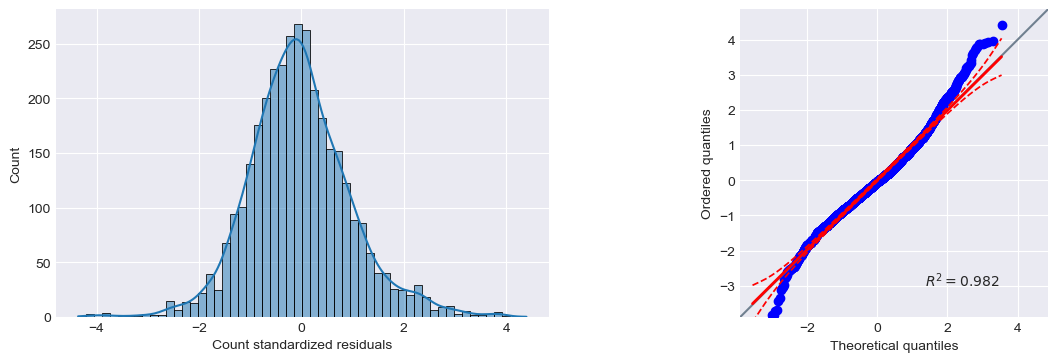

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
count_residuals = test_set['count'] - count_test_pred
count_standardized_residuals = count_residuals / count_residuals.std()
sns.histplot(count_standardized_residuals, kde=True, ax=axes[0])
axes[0].set_xlabel('Count standardized residuals')
pg.qqplot(count_standardized_residuals, dist='norm', ax=axes[1])

Our normalized RMSE for `count` is the same as for `registered` but residuals are looking even better with an almost perfect distribution. This model is thus the one that satisfies the most the regression model assumptions (except from the fact that there is some degree of autocorrelation in y because of the nature of the data). 

*Ideally, I should also maybe look for patterns in residuals by plotting them against features but I am afraid I do not have the time for that.*

-------

**Comparison of results with regularization and PCA as a way to select features**

In this part, I just want to quickly build a model for `count` (as it seems to be the easiest to predict) using Lasso regularization (because by nature it tends to assign 0 coefficients to more features than Ridge) and PCA as ways to select features to compare the results with forward selection.

I won't describe in detail everything, I just want a quick comparison.

We can start with Lasso regression (note that we will use the default $\lambda$, keeping in mind that the choice of $\lambda$ can have a big impact, thus results should be taken with a grain of salt).

EDIT : After doing Logistic Regression, I learned that scaling can also help for regularization as it ensures that regularization techniques, like L1 and L2, are applied uniformly across all features. I won't do it all over again as we did not have problems and results were satisfying but it is good to know for next time.

In [65]:
from sklearn import linear_model
regularized_model = linear_model.Lasso()
regularized_model.fit(df_REG.drop(['casual', 'registered', 'count'], axis=1), df_REG['count'])
regularization_prediction = regularized_model.predict(test_set.drop(['casual', 'registered', 'count'], axis=1))
# normalized rmse 
mean_squared_error(test_set['count'], regularization_prediction, squared=False) / test_set['count'].mean()

0.4880578391858746

In [66]:
regularized_model.coef_

array([  5.72481581,  -0.69620095,  -4.71339236,  21.47270843,
       -35.7591709 ,  82.34371639, -45.32162727,  -5.13712042,
       -51.99759723, -64.52636596, -67.73014149,  -1.54779059,
        -0.        ,  -5.09743809,   0.99188013,  12.88879982,
         0.        , 158.75207998, 135.98954623])

<AxesSubplot: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

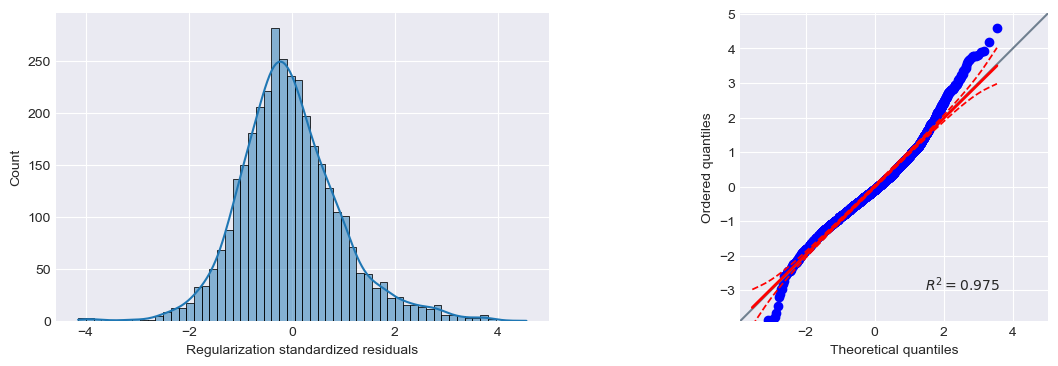

In [67]:
#show residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
regularization_residuals = test_set['count'] - regularization_prediction
regularization_standardized_residuals = regularization_residuals / regularization_residuals.std()
sns.histplot(regularization_standardized_residuals, kde=True, ax=axes[0])
axes[0].set_xlabel('Regularization standardized residuals')
pg.qqplot(regularization_standardized_residuals, dist='norm', ax=axes[1])

RMSE is slightly better than with forward selection, but residuals have a slightly lower $R^2$. The two models are comparable in terms of performance, but I would stick with the one from forward selection as it is simplier and thus more interpretable and less subject to overfitting. In fact Lasso regresssion keeps (assigns non-zero coefficients) to 17 out of 19 features. Note that forward selection itself kept 18 features but the fact that it provides "an ordering" of features with an associated decrease in RMSE allows us to make the cut earlier. Lasso does not provide this ordering so it is more prone to including correlated features and thus overfitting. For lasso regression, it would be advisable to remove correlated features before as we cannot do it afterward like with forward selection.

We can now try PCA, we need to scale our features first for PCA as scale has an impact on it.

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pca = PCA()
pca_scaler = StandardScaler()
pca.fit(pca_scaler.fit_transform(df_REG.drop(['casual', 'registered', 'count'], axis=1)))
pca.explained_variance_ratio_

array([0.16588387, 0.1547296 , 0.10170207, 0.09541375, 0.07415389,
       0.06391391, 0.05315133, 0.05264494, 0.05189031, 0.04464635,
       0.04135355, 0.03576312, 0.01816735, 0.01459521, 0.01035306,
       0.00977096, 0.00501669, 0.0035781 , 0.00327197])

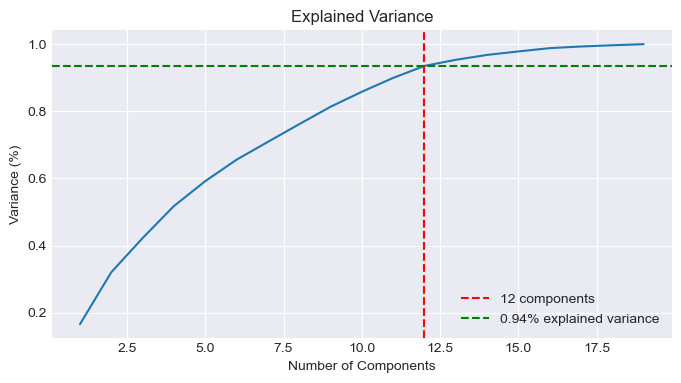

In [69]:
plt.figure(figsize=(8, 4))
variance_curve_points = np.cumsum(pca.explained_variance_ratio_)
plt.plot([i+1 for i in range(len(variance_curve_points))],variance_curve_points)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.axvline(x=12, color='r', linestyle='--', label='12 components')
plt.axhline(y=variance_curve_points[11], color='g', linestyle='--', label=f'{variance_curve_points[11]:.2f}% explained variance')
plt.legend()
plt.show()

We can try keeping 12 components as there is an elbow at this point and it explains 94% of the variance.

In [70]:
pca = PCA(n_components=12)
components = pca.fit_transform(pca_scaler.fit_transform(df_REG.drop(['casual', 'registered', 'count'], axis=1)))

In [71]:
PCA_model = LinearRegression(fit_intercept=True)
PCA_model.fit(components, df_REG['count'])

LinearRegression()

In [72]:
df_REG.drop(['casual', 'registered', 'count'], axis=1).columns

Index(['temperature', 'humidity', 'season_summer', 'season_fall',
       'season_winter', 'year_2012', 'workingday_Yes', 'weather_OK',
       'weather_Bad', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
       'weekday_sin', 'weekday_cos', 'is_peak_time', 'is_larger_peak_time',
       'is_peak_work_commute', 'is_work_commute'],
      dtype='object')

In [73]:
pca_prediction = PCA_model.predict(pca.transform(pca_scaler.transform(test_set.drop(['casual', 'registered', 'count'], axis=1))))
mean_squared_error(test_set['count'], pca_prediction, squared=False) / test_set['count'].mean()

0.5240740217696318

<AxesSubplot: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

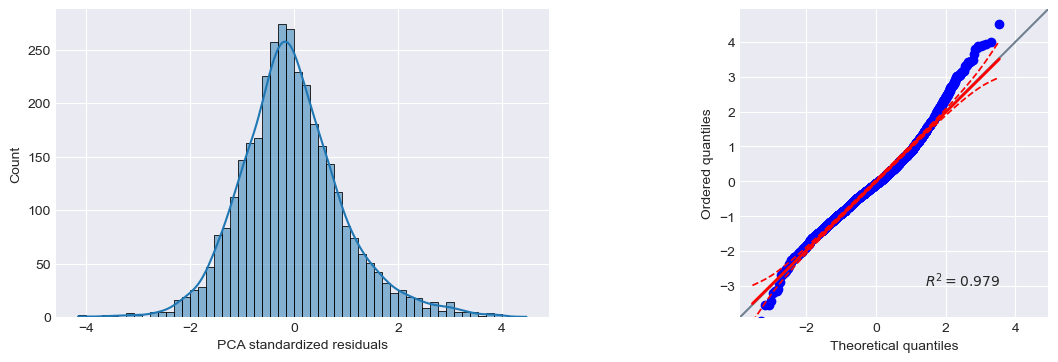

In [74]:
# show residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
pca_residuals = test_set['count'] - pca_prediction
pca_standardized_residuals = pca_residuals / pca_residuals.std()
sns.histplot(pca_standardized_residuals, kde=True, ax=axes[0])
axes[0].set_xlabel('PCA standardized residuals')
pg.qqplot(pca_standardized_residuals, dist='norm', ax=axes[1])

The model fitted with PCA components has a slightly higher RMSE compared to forward selection and a slightly lower $R^2$ for residuals. Again the model is comparable, but I would keep the one from forward selection for interpretability (PCA components are much more difficult to interpret) and lower feature number.

---------

**Note on feature engineering**

After finishing the regression part, I realized that the way I computed functions on my numerical variables was not very smart. In fact some plots suggested quadratric relationships but squaring the feature did not really help. Before squaring I should have centered the variable to transform using the "bottom or top of the curve" and then squared it. Otherwise squaring does not really help if all the points are already positive (as it is the case for `temperature` and `humidity` for example). 

I will treat `hour` as numerical to demonstrate what I mean.

<AxesSubplot: xlabel='hour', ylabel='casual'>

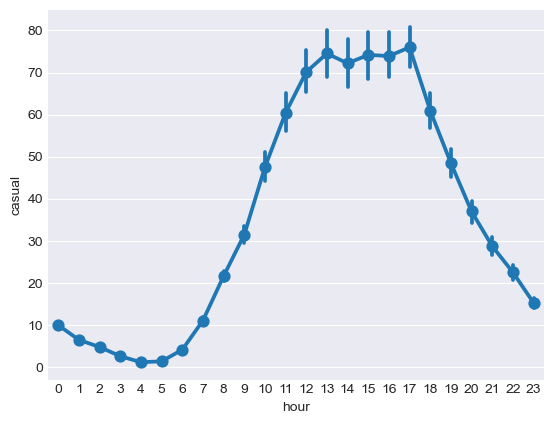

In [75]:
sns.pointplot(x='hour', y='casual', data=train_set)

<AxesSubplot: xlabel='hour', ylabel='casual'>

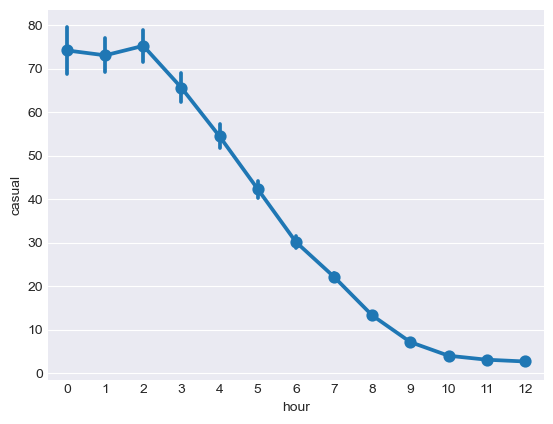

In [76]:
hour_shifted_abs = np.abs(train_set.hour.apply(lambda x: x+24 if x<4 else x) - 15)
hour_sa_x_casual = pd.concat([train_set.casual, hour_shifted_abs], axis=1)
sns.pointplot(x='hour', y='casual', data=hour_sa_x_casual)

In [77]:
hour_sa_x_casual.corr()

,casual,hour
casual,1.000000,-0.542921
hour,-0.542921,1.000000


We can see that by applying a shifting and then taking the absolute value of the shifted points (not squaring but has the same effect for signs, but absolute gave better correlation) we get an almost linear relationship and a pretty good correlation. I tried using this modified version of `hour` in the models to see if there was any improvement. This new feature was one of the first to be picked up by the models (instead of `hour_sin` and `hour_cos`) but the end score of the models did not improve. I also try to re-feature-engineer temperature or humidity and the results where not better either. 

The end results not necessarily improving and the time being limited before submission deadline, I did not redo all the feature engineering part and updated the following regression part. However, I wanted to mention this.

# Task 4: Which of the 3 target columns is easiest to predict accurately?

This has already been answered in the previous section, but in my case the easiest target to predict accurately is `count` (better normalized RMSE and residuals distribution), followed closely by `registered` and then `casual` which is quite further away in terms of normalized RMSE and residuals skewness (I may have missed something for this one, it would merit further investigation).

# Task 5: Using this "preferred target", derive a new target whose values are the grouped label.

What we need to do now is to :
 1. Compute the 25th, 50th and 75th percentiles of `count` on the train set
 2. Create a new target column based on these quartiles with 4 levels : `Q1`, `Q2`, `Q3`, `Q4` both on the train and test set.
 3. Assign a label on each row of the train and test set based on `count` value.

Let's start with the first step. We will make copies of our train and test set to avoid modifying them as linear regression does not need our new target.

In [78]:
clf_train = df_REG.copy().drop(['casual', 'registered'], axis=1)
clf_test = test_set.copy().drop(['casual', 'registered'], axis=1)

In [79]:
quantiles = clf_train.quantile([0.25, 0.5, 0.75])['count']
quantile25limit = quantiles[0.25]
quantile50limit = quantiles[0.5]
quantile75limit = quantiles[0.75]
quantiles

0.25     39.0
0.50    143.0
0.75    282.0
Name: count, dtype: float64

We can now create our new target columns in both dataframes and assign labels based on `count`.

In [80]:
# create target and assign quantile for train set
clf_train['countQ'] = np.nan
clf_train.loc[clf_train['count'] <= quantile25limit, 'countQ'] = 'Q1'
clf_train.loc[(clf_train['count'] <= quantile50limit) & (clf_train['count'] > quantile25limit), 'countQ'] = 'Q2'
clf_train.loc[(clf_train['count'] <= quantile75limit) & (clf_train['count'] > quantile50limit), 'countQ'] = 'Q3'
clf_train.loc[clf_train['count'] > quantile75limit, 'countQ'] = 'Q4'
clf_train.countQ = pd.Categorical(clf_train.countQ, categories=['Q1', 'Q2', 'Q3', 'Q4'], ordered=True)

# same for test set
clf_test['countQ'] = np.nan
clf_test.loc[clf_test['count'] <= quantile25limit, 'countQ'] = 'Q1'
clf_test.loc[(clf_test['count'] <= quantile50limit) & (clf_test['count'] > quantile25limit), 'countQ'] = 'Q2'
clf_test.loc[(clf_test['count'] <= quantile75limit) & (clf_test['count'] > quantile50limit), 'countQ'] = 'Q3'
clf_test.loc[clf_test['count'] > quantile75limit, 'countQ'] = 'Q4'
clf_test.countQ = pd.Categorical(clf_test.countQ, categories=['Q1', 'Q2', 'Q3', 'Q4'], ordered=True)

# drop count
clf_train.drop('count', axis=1, inplace=True)
clf_test.drop('count', axis=1, inplace=True)

clf_train.head()

,temperature,humidity,season_summer,season_fall,season_winter,year_2012,workingday_Yes,weather_OK,weather_Bad,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,is_peak_time,is_larger_peak_time,is_peak_work_commute,is_work_commute,countQ
date,,,,,,,,,,,,,,,,,,,,
2011-01-15 11:00:00,8.20,55.0,0,0,1,0,0,0,0,0.258819,-9.659258e-01,5.000000e-01,0.866025,-0.781831,0.623490,0,0,0,0,Q2
2011-10-25 18:00:00,21.32,42.0,0,1,0,0,1,0,0,-1.000000,-1.836970e-16,-8.660254e-01,0.500000,0.974928,-0.222521,1,1,1,1,Q4
2011-12-07 03:00:00,18.86,100.0,0,1,0,0,1,0,1,0.707107,7.071068e-01,-2.449294e-16,1.000000,0.433884,-0.900969,0,0,0,0,Q1
2011-04-03 18:00:00,18.86,31.0,0,0,0,0,0,1,0,-1.000000,-1.836970e-16,8.660254e-01,-0.500000,0.000000,1.000000,1,1,0,0,Q3
2011-12-25 06:00:00,8.20,75.0,0,0,1,0,0,0,0,1.000000,6.123234e-17,-2.449294e-16,1.000000,0.000000,1.000000,0,0,0,0,Q1


Perfect, let's just look at the balance of our new target, we should have approximately the same number of rows for each quartile since we divided in quartiles.

In [81]:
clf_train.countQ.value_counts()

Q3    3485
Q1    3481
Q2    3473
Q4    3464
Name: countQ, dtype: int64

Perfect ! The reason why it is not perfectly equal is because if we have several times the quartilelimit value, when we assign the label, we will assign the same label to all these rows. 

# Task 6: Use _two_ classification procedures to predict these demand quartiles.

For classification, we will use two different algorithms :
- Logistic Regression
- K Nearest Neighbors

The reason is that first we have studied them in class, and second they take the same kind of input features (numerical) as linear regression, which will save us quite some time as we can use the same features as previously. 

The only thing we need to do is to scale (only for KNN) our features as KNN is very sensitive to scale. We will use the `StandardScaler`. 

EDIT : We will also scale the data for logistic regression as it helps with convergence.

We will use the same forward selection approach as previously to select the best features for each model, but using a different metric obviously as regression metrics do not apply to classification. As our classes are (almost) perfectly balanced, we will use F1 micro score as our metric. F1 score has the nice property of being bound between 0 and 1, which makes interpretation and comparison easy.

For KNN, once we will have selected a good set on features using forward selection we will use GridSearch tu select the best distance metric and value of K. It would be better to look for the best set of features and best hyperparameters at the same time, but it would also be much more computationally expensive. Thus we will first select the best set of features using default hyperparameters (default distance is euclidian, and we will use $K=sqrt(N)$ with $N$ being the number of rows) and then look for the best hyperparameters for this set of features.

We will use the default hyperparameters for logistic regression.

*Note : For best performance, some more EDA and feature engineering might be appropriate to select features with classification in mind, however our features are certainely a good starting point so we will use these ones.*

Before anything we can scale our train and test sets using the `StandardScaler`.

In [82]:
clf_scaler = StandardScaler() 
clf_scaler.fit(clf_train.drop('countQ', axis=1))
clf_X_train = pd.DataFrame(clf_scaler.transform(clf_train.drop('countQ', axis=1)), columns=clf_train.drop('countQ', axis=1).columns)
clf_y_train = clf_train['countQ']
clf_X_test = pd.DataFrame(clf_scaler.transform(clf_test.drop('countQ', axis=1)), columns=clf_test.drop('countQ', axis=1).columns)
clf_y_test = clf_test['countQ']

-----------

**We can start with logistic regression.**

Let's first create our forward selection function. It is essentially the same as for regression but with a different metric and a different model. I did not create a more general function for all models to keep the code clear as for example for KNN we will not fit a model with a constant only (which would make no sense).

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

def forward_selection_logistic_regression(features, target, cv=10):
    model = LogisticRegression(fit_intercept=False)
    
    remaining_features = list(features.columns)
    selected_features = []
    model_score = []
    
    # compute the score for the smallest model with only a constant fitted (no need for cross validation for that)
    X = pd.DataFrame({'constant':np.ones(len(features))})
    X_train, X_val, y_train, y_val = train_test_split(X, target, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    Y_pred = model.predict(X_val)
    model_score.append(f1_score(y_val, Y_pred, average='micro'))
    
    model = LogisticRegression(fit_intercept=True)
    last_max_score_feature = None
    last_max_score = None
    while last_max_score == None and len(remaining_features) > 0:
        #print(f"\n---{len(selected_features)} features selected for now---")
        for feature in remaining_features:
            X = features[selected_features + [feature]]
            cv_score = cross_val_score(model, X, target, cv=cv, scoring='f1_micro').mean()
            #print(f"Trying {feature} - CV score: {cv_score}")
            if last_max_score is None or cv_score > last_max_score:
                last_max_score = cv_score
                last_max_score_feature = feature
        if last_max_score > model_score[-1]:
            #print(f"Adding {last_max_score_feature} with score {last_max_score}")
            selected_features.append(last_max_score_feature)
            remaining_features.remove(last_max_score_feature)
            model_score.append(last_max_score)
            last_max_score = None
            last_max_score_feature = None
            
    selected_features = ["constant"] + selected_features
    return selected_features, model_score

Our helper function is also slightly different as we use a score rather than an error metric.

In [84]:
def show_clf_forward_selection_results(selected_features, model_score):
    # create a dataframe with selected features, their score and percentage increase from previous one
    df = pd.DataFrame({'feature':selected_features, 'score':model_score})
    # add column with percentage increase from previous score, put 0 for first feature
    df['pct_score_increase'] = df.score.pct_change().fillna(0)
    return df

We can now use forward selection to find the best features for our logistic regression model.

*Note : this takes 1min21s on my computer so be aware that it is not instantaneous.*

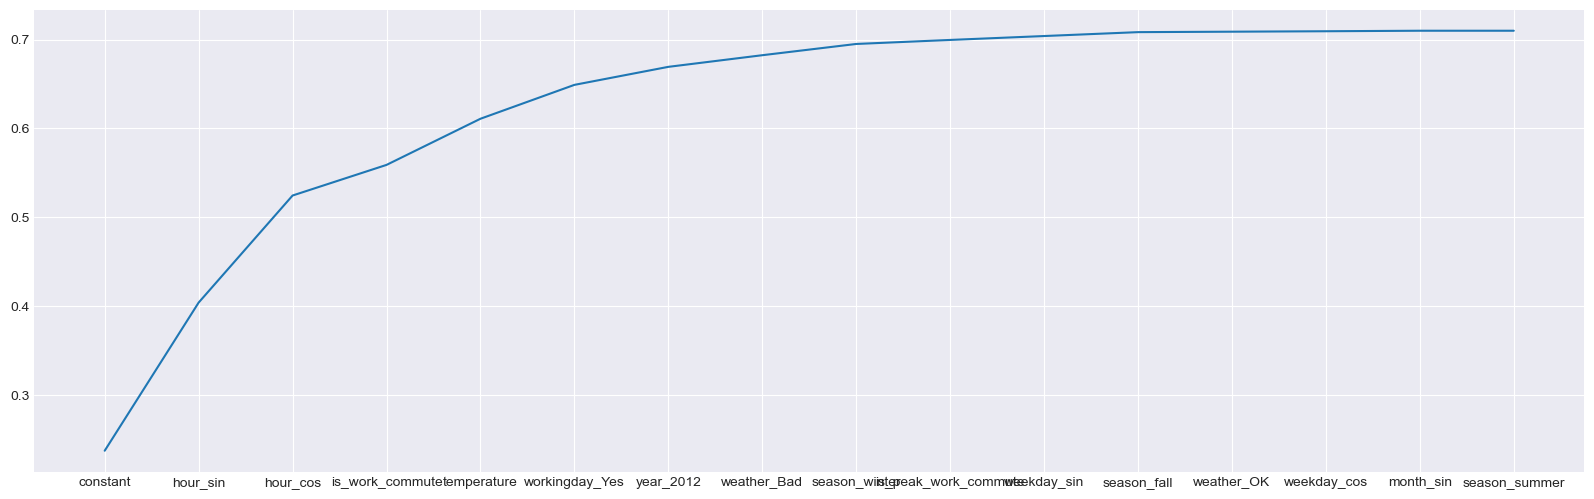

In [85]:
selected_features, model_score = forward_selection_logistic_regression(clf_X_train, clf_y_train, cv=10)
fig = plt.figure(figsize=(20, 6))
plt.plot(selected_features, model_score)

In [86]:
show_clf_forward_selection_results(selected_features, model_score)

,feature,score,pct_score_increase
0,constant,0.237325,0.000000e+00
1,hour_sin,0.404012,7.023610e-01
2,hour_cos,0.524490,2.982032e-01
3,is_work_commute,0.558943,6.568892e-02
4,temperature,0.610875,9.291057e-02
5,workingday_Yes,0.648996,6.240361e-02
6,year_2012,0.669280,3.125403e-02
7,weather_Bad,0.682371,1.955975e-02
8,season_winter,0.695029,1.855101e-02
9,is_peak_work_commute,0.699560,6.519342e-03


As we can see above, the 9 first features selected are the same as the linear regression model. However, for logistic regression I would only keep the first 8 features as the last 9th feature only provide a <1% score increase. This makes sense as with `is_work_commute` = 1 are certainely already all in the highest quartile, so knowing that we are in the peak time of work commute with the 9th feature does not give us a lot more information. 

We can rebuild the model with the entire training data (no cross-validation) and only the selected features to compute a final F1-score on the **test set** to compare the model with KNN and Linear regression later on.

In [87]:
final_log_reg_model = LogisticRegression(fit_intercept=True)
log_reg_kept_features = ['hour_sin', 'hour_cos', 'is_work_commute', 'temperature', 'workingday_Yes', 'year_2012', 'weather_Bad', 'season_winter']
final_log_reg_model.fit(clf_X_train[log_reg_kept_features], clf_y_train)

LogisticRegression()

Now we can evaluate our model on the test set.

In [88]:
log_reg_pred = final_log_reg_model.predict(clf_X_test[log_reg_kept_features])
log_reg_F1 = f1_score(clf_y_test, log_reg_pred, average='micro')
print(f"F1: {log_reg_F1}")

F1: 0.6936133486766398


From what I saw online 0.69 is a pretty good score for F1 micro score. We can also look at the confusion matrix to see how our model performs for each class.

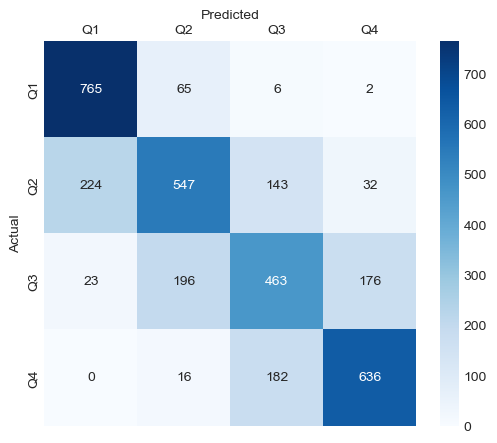

In [89]:
log_reg_cf = pd.crosstab(clf_y_test, log_reg_pred, rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(6,5))
g = sns.heatmap(log_reg_cf, annot=True, cmap="Blues", fmt='g')
g.xaxis.set_ticks_position("top")
g.xaxis.set_label_position('top')

The highest coefficient are on the diagonal so this is a good sign, however the ones alongside the diagonal are also quite high which is bad but at least it shows that our model is not completely off when it makes a mistakes (other coefficients are low).

-------

**We can now look at K Nearest Neighbors.**

We first define our forward selection function.

In [90]:
from sklearn.neighbors import KNeighborsClassifier

def forward_selection_KNN(features, target, cv=10, k=int(len(clf_X_train)**0.5)):  
    model = KNeighborsClassifier(n_neighbors=k)
    remaining_features = list(features.columns)
    selected_features = []
    model_score = []
    last_max_score_feature = None
    last_max_score = None
    while last_max_score == None and len(remaining_features) > 0:
        #print(f"\n---{len(selected_features)} features selected for now---")
        for feature in remaining_features:
            X = features[selected_features + [feature]]
            cv_score = cross_val_score(model, X, target, cv=cv, scoring='f1_micro').mean()
            #print(f"Trying {feature} - CV score: {cv_score}")
            if last_max_score is None or cv_score > last_max_score:
                last_max_score = cv_score
                last_max_score_feature = feature
        if len(model_score) == 0 or last_max_score > model_score[-1]:
            #print(f"Adding {last_max_score_feature} with score {last_max_score}")
            selected_features.append(last_max_score_feature)
            remaining_features.remove(last_max_score_feature)
            model_score.append(last_max_score)
            last_max_score = None
            last_max_score_feature = None
            
    return selected_features, model_score

We can now use forward selection to find the best features for our KNN model.

*This also takes more than 1min*

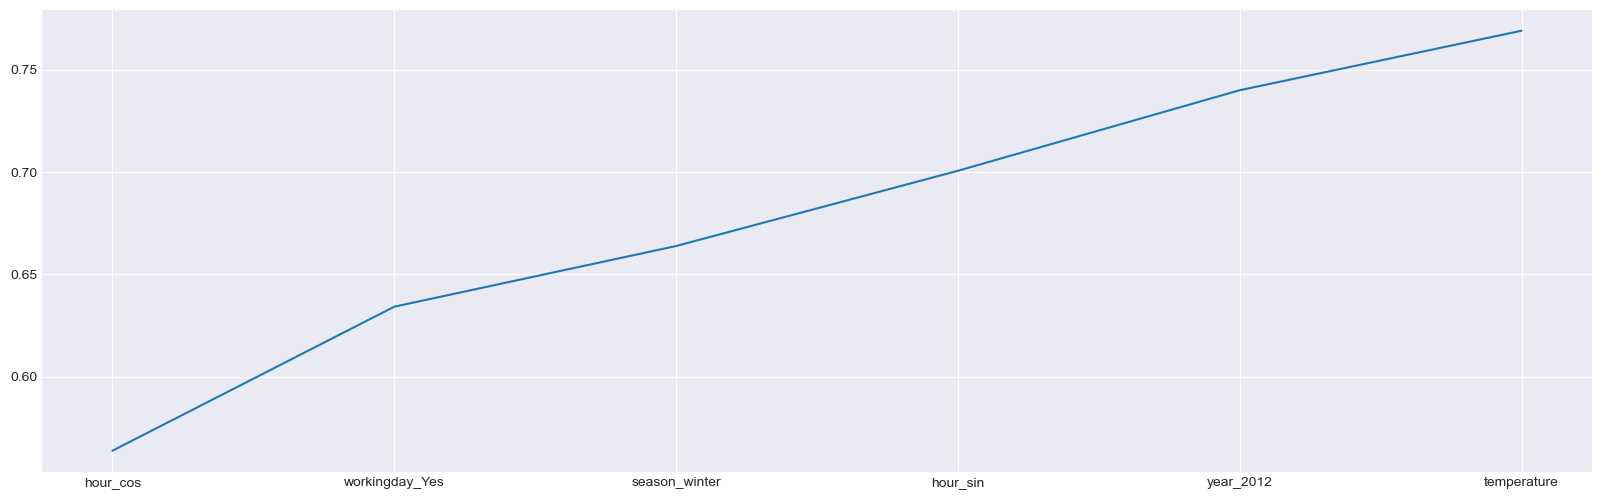

In [91]:
selected_features, model_score = forward_selection_KNN(clf_X_train, clf_y_train, cv=10)
fig = plt.figure(figsize=(20, 6))
plt.plot(selected_features, model_score)

In [92]:
show_clf_forward_selection_results(selected_features, model_score)

,feature,score,pct_score_increase
0,hour_cos,0.563833,0.000000
1,workingday_Yes,0.634180,0.124765
2,season_winter,0.663813,0.046726
3,hour_sin,0.700568,0.055369
4,year_2012,0.739912,0.056160
5,temperature,0.768970,0.039273


We can see that for KNN, forward selection is much more selective. It keeps only 6 features, so we will keep them all as they all contribute to increasing the score significantly and 6 is not too much. Also the F1 score seems pretty good.

As explained at the beginning of this section we will now use GridSearch to find the best hyperparameters (distance and k) for our model. We will use the same metric as for forward selection.

In [93]:
knn_kept_features = ['hour_cos', 'workingday_Yes', 'season_winter', 'hour_sin', 'year_2012', 'temperature']

*The following cell takes around 10 minutes to run on my computer*

In [94]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipe = Pipeline([('knn', KNeighborsClassifier())])
search_space = [{'knn__n_neighbors': range(3, int(len(clf_X_train)**0.5)), 'knn__metric': ['euclidean', 'manhattan', 'chebyshev']}]
clf = GridSearchCV(pipe, search_space, cv=5, verbose=1, scoring='f1_micro')
clf.fit(clf_X_train[knn_kept_features], clf_y_train)

# best pca component number
clf.best_params_

Fitting 5 folds for each of 342 candidates, totalling 1710 fits


{'knn__metric': 'manhattan', 'knn__n_neighbors': 18}

GridSearch suggests that the best combination of hyperparameters is manhattan distance and K=18. K seems low compared to $sqrt(N)=114$ but gridsearch uses 5-fold cross validation so the model should not be subject to overfitting with these parameters otherwise the cv score would be bad.

We can now rebuild the model with the entire training data (no cross-validation), only the selected features and the best distance and K to compute a final F1-score on the **test set** to compare the model with Linear regression and Logistic Regression.

In [95]:
final_knn_model = KNeighborsClassifier(n_neighbors=clf.best_params_['knn__n_neighbors'], metric=clf.best_params_['knn__metric'])
final_knn_model.fit(clf_X_train[knn_kept_features], clf_y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=18)

We can now evaluate our model on the test set.

In [96]:
knn_pred = final_knn_model.predict(clf_X_test[knn_kept_features])
knn_F1 = f1_score(clf_y_test, knn_pred, average='micro')
print(f"F1: {knn_F1}")

F1: 0.7968929804372842


In fact we can see that the F1 score is very good on the training set as well.

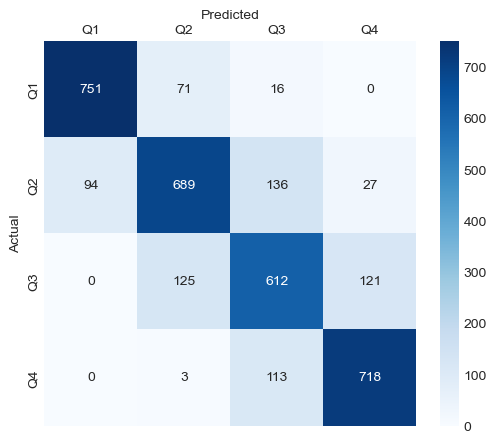

In [97]:
knn_cf = pd.crosstab(clf_y_test, knn_pred, rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(6,5))
g = sns.heatmap(knn_cf, annot=True, cmap="Blues", fmt='g')
g.xaxis.set_ticks_position("top")
g.xaxis.set_label_position('top')

The confusion matrix confirms that our model is good with high diagonal coefficients, and lower coefficients alongside the diagonal than for Logistic Regression.

*Added later :*  I will try to use gower distance to see if I get better results.

In [98]:
import gower
dist_matrix = gower.gower_matrix(clf_X_train[knn_kept_features])
# train another knn model with gower distance and grid search for best k
pipe = Pipeline([('knn', KNeighborsClassifier(metric='precomputed'))])
search_space = [{'knn__n_neighbors': range(3, 30)}]
clf = GridSearchCV(pipe, search_space, cv=5, verbose=1, scoring='f1_micro')
clf.fit(dist_matrix, clf_y_train)
clf.best_params_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


{'knn__n_neighbors': 22}

In [99]:
# compute final model using best k
final_gower_knn_model = KNeighborsClassifier(n_neighbors=clf.best_params_['knn__n_neighbors'], metric='precomputed')
final_gower_knn_model.fit(dist_matrix, clf_y_train)
# Precomputed matrix of distances between test instances and training instances
dist_matrix_test = gower.gower_matrix(clf_X_test[knn_kept_features], clf_X_train[knn_kept_features])
# evaluate on test set
gower_knn_pred = final_gower_knn_model.predict(dist_matrix_test)
gower_knn_F1 = f1_score(clf_y_test, gower_knn_pred, average='micro')
print(f"F1: {gower_knn_F1}")


F1: 0.7888377445339472


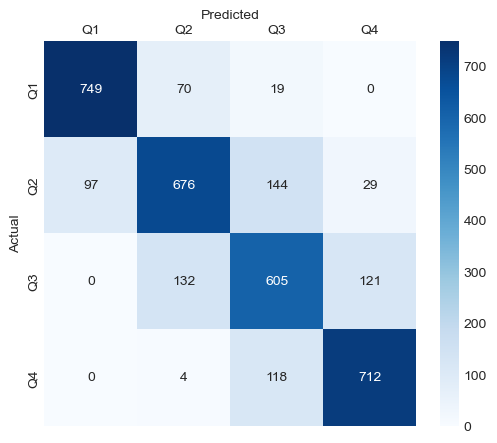

In [100]:
gower_knn_cf = pd.crosstab(clf_y_test, gower_knn_pred, rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(6,5))
g = sns.heatmap(gower_knn_cf, annot=True, cmap="Blues", fmt='g')
g.xaxis.set_ticks_position("top")
g.xaxis.set_label_position('top')

# Task 7: Does regression or classification provide the best classification accuracy on the test set? Why?

To answer this question, we first need to compute classification accuracy for our regression model. We will convert our predicted `count` to quartiles using the quartiles limits found earlier and then compute the F1 micro score and confusion matrix. We will also compute classification accuracy for our 3 models. 

In [101]:
def get_quartile(value):
    if value <= quantile25limit:
        return 'Q1'
    elif value <= quantile50limit:
        return 'Q2'
    elif value <= quantile75limit:
        return 'Q3'
    else:
        return 'Q4'

count_test_pred_Q = pd.Series(count_test_pred).apply(get_quartile)
count_test_pred_Q

0       Q4
1       Q3
2       Q1
3       Q4
4       Q1
        ..
3471    Q1
3472    Q2
3473    Q2
3474    Q3
3475    Q3
Length: 3476, dtype: object

We can compute our F1 score for regression. We will also display the confusion matrix.

In [102]:
linear_regression_F1 = f1_score(clf_y_test, count_test_pred_Q, average='micro')
print(f"F1: {linear_regression_F1}")

F1: 0.6185270425776754


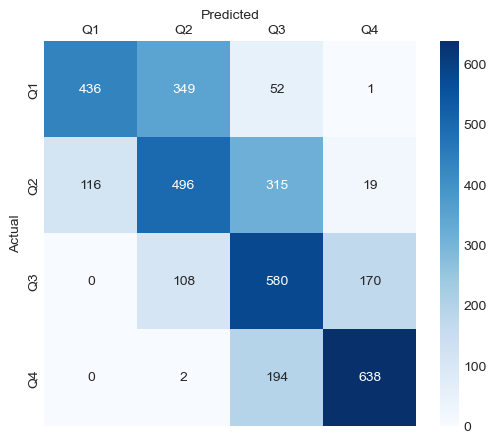

In [103]:
linear_reg_cf = pd.crosstab(clf_y_test, list(count_test_pred_Q), rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(6,5))
g = sns.heatmap(linear_reg_cf, annot=True, cmap="Blues", fmt='g')
g.xaxis.set_ticks_position("top")
g.xaxis.set_label_position('top')

We can see that the F1 score is less godd than for KNN anf Logistic Regression. We can see in the confusion matrix that our linear regression model especially struggles to predict lower quartiles accuratly.

Before concluding, we can compute classification accuracy for our 3 models.

In [104]:
# compute classification accuracy for our 3 models 
from sklearn.metrics import accuracy_score
knn_accuracy = accuracy_score(clf_y_test, knn_pred)
log_reg_accuracy = accuracy_score(clf_y_test, log_reg_pred)
linear_reg_accuracy = accuracy_score(clf_y_test, count_test_pred_Q)
print(f"KNN accuracy: {knn_accuracy:.3f}, logistic regression accuracy: {log_reg_accuracy:.3f}, linear regression accuracy: {linear_reg_accuracy:.3f}")

KNN accuracy: 0.797, logistic regression accuracy: 0.694, linear regression accuracy: 0.619


We can see that our best model for classification is KNN, followed by Logistic Regression and finally Linear Regression in last place. The fact that Linear regression is last, makes sense as it is fitted to reduce the numeric error among the entire dataset while KNN and and logistic regression are fitted to classify each row into a quartile.